# Import Packages

In [1]:
# import packages

# general tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
import warnings

# RDKit
from rdkit import Chem, RDLogger

# scikit-learn
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
# set global options

RDLogger.DisableLog('rdApp.*')
warnings.filterwarnings("ignore")

In [3]:
# import functions written for this project

from modules import *

In [4]:
# import and check funtionality of pytorch / pytorch geometric

import torch
import torch_geometric

print("Pytorch version = ", torch.__version__)
print("Pytorch Geometric version = ", torch_geometric.__version__)
print("CUDA version = ", torch.version.cuda)
print("CUDA available = ", torch.cuda.is_available())
print("Random Pytorch test tensor = ", torch.rand(1))

Pytorch version =  1.10.2+cu113
Pytorch Geometric version =  2.0.3
CUDA version =  11.3
CUDA available =  True
Random Pytorch test tensor =  tensor([0.7620])


# Load and Prepare Data

In [43]:
# create dictionary to collect experimental settings
settings_dict = {}

In [41]:
# choose ChEMBL dopamine D2 data set

datafolder_filepath = "data/chembl_dopamine_d2/"
settings_dict["target_name"] = "chembl_dopamine_d2"
activity_type = "Ki [nM]"

In [44]:
# or choose ChEMBL factor Xa data set

datafolder_filepath = "data/chembl_factor_xa/"
settings_dict["target_name"] = "chembl_factor_xa"
activity_type = "Ki [nM]"

In [38]:
# or choose PostEra SARS-CoV 2 Mpro data set

datafolder_filepath = "data/postera_sars_cov_2_mpro/"
settings_dict["target_name"] = "postera_sars_cov_2_mpro"
activity_type = "f_avg_IC50 [uM]"

In [45]:
# load clean data

dataframe = pd.read_csv(datafolder_filepath + "molecule_data_clean.csv", sep = ",")
settings_dict["n_molecules"] = len(dataframe)
display(dataframe)

,SMILES,Ki [nM]
0,O=C1CN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CCN1Cc1cc2cn...,1219.0
1,O=C(CN1CCN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CC1=O)NC...,59.0
2,C[C@H]1CC[C@@H](Oc2cccc(-c3nc4cc(C(=N)N)c(F)cc...,38000.0
3,COc1cccc(S(=O)(=O)Nc2cccn(CC(=O)NCc3ccc(C(=N)N...,76.8
4,Cc1nn(-c2ccc3nc(N)nc(N)c3c2)c(C(=O)Nc2ccc(-c3c...,16.0
...,...,...
3600,Cc1cc2c(cc1C)[nH]c([C@@H](CNC(=O)c1ccc(-n3cnnc...,1010.0
3601,Cc1ccc2c(c1)c(C)c1CC[C@](NC(=O)c3c(Cl)cc(-n4cn...,1748.0
3602,N=C(N)c1ccc(CNC(=O)[C@@H]2Cc3ccc(cc3)NC(=O)CCN...,11530.0
3603,NCc1ccc(CNC(=O)[C@@H]2Cc3ccc(cc3)NC(=O)CCN3CCN...,77600.0


Shape of x_smiles =  (1924,)
CCNC(=O)CN1CC2(CCN(c3cncc4ccccc34)C2=O)c2cc(Cl)ccc2S1(=O)=O


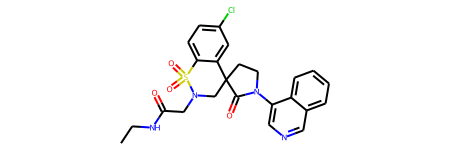

In [8]:
# construct array with SMILES strings

x_smiles = dataframe["SMILES"].values

print("Shape of x_smiles = ", x_smiles.shape)
print(x_smiles[0])
display(Chem.MolFromSmiles(x_smiles[0]))

Mean value (y) =  -0.9180193183732708
Standard deviation (y) =  1.04434733236911
Maximum value (y) =  2.573819647563703
Minimum value (y) =  -2.296665190261531
Shape (y) =  (1924,)


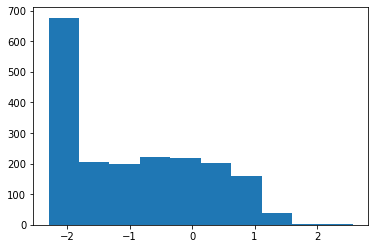

In [9]:
# construct array with activity labels y (via applying the negative decadic logarithm to the experimental activity measurements)

y = -np.log10(dataframe[activity_type].values.astype(float))

print("Mean value (y) = ", np.mean(y))
print("Standard deviation (y) = ", np.std(y))
print("Maximum value (y) = ", np.amax(y))
print("Minimum value (y) = ", np.amin(y))
print("Shape (y) = ", y.shape)
plt.hist(y)
plt.show()

In [10]:
# create dictionary which maps SMILES strings to their activity labels

x_smiles_to_y_dict = dict(list(zip(x_smiles, y)))

In [11]:
# import matched molecular pair (MMP) dataframe

dataframe_mmps = pd.read_csv(datafolder_filepath + "MMP_data_clean.csv",
                             sep = ",",
                             header = 0)

print("Number of matched molecular pairs (MMPs) = ", len(dataframe_mmps))
display(dataframe_mmps.head(n = 3))

Number of matched molecular pairs (MMPs) =  12594


,smiles_1,smiles_2,transformation,constant_part
0,COc1cc(Br)ccc1Nc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc2...,COc1ncc(Br)cc1Nc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc2...,[*:1]c1ccc([*:2])c([*:3])c1>>[*:1]c1cnc([*:3])...,[*:1]Br.[*:2]Nc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23...
1,O=C(Cc1cc(Cl)cc(NCc2ccc(Br)cc2)c1)Nc1cncc2ccccc12,COc1cc(Br)ccc1Nc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc2...,[*:1]NCc1ccc([*:2])cc1>>[*:1]Nc1ccc([*:2])cc1OC,[*:2]Br.[*:1]c1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23)c1
2,O=C(Cc1cc(Cl)cc(NCc2ccc(Br)cc2)c1)Nc1cncc2ccccc12,COc1ncc(Br)cc1Nc1cc(Cl)cc(CC(=O)Nc2cncc3ccccc2...,[*:1]NCc1ccc([*:2])cc1>>[*:1]Nc1cc([*:2])cnc1OC,[*:2]Br.[*:1]c1cc(Cl)cc(CC(=O)Nc2cncc3ccccc23)c1


In [12]:
# construct MMP array and binary MMP labels for AC-prediction (we delete half-cliffs)

# create array with all MMPs (including half-cliffs)
X_smiles_mmps = dataframe_mmps.values[:,0:2]

# create array with all MMP cores
x_smiles_mmp_cores = dataframe_mmps.values[:,3]

# label ACs with 1 and other MMPs (= half-cliffs and non-ACs) with 0
y_mmps = np.array([int(abs(x_smiles_to_y_dict[smiles_1] - x_smiles_to_y_dict[smiles_2]) >= 2) 
                   for [smiles_1, smiles_2] in X_smiles_mmps])

# determine indices for MMPs which are half-cliffs (these should be deleted)
y_mmps_half_cliffs = np.array([int(1 < abs(x_smiles_to_y_dict[smiles_1] - x_smiles_to_y_dict[smiles_2]) < 2) 
                               for [smiles_1, smiles_2] in X_smiles_mmps])
ind_delete = np.ndarray.flatten(np.argwhere(y_mmps_half_cliffs > 0))

# delete MMPs which are half-cliffs
X_smiles_mmps = np.delete(X_smiles_mmps, ind_delete, axis = 0)
settings_dict["n_mmps"] = len(X_smiles_mmps)
x_smiles_mmp_cores = np.delete(x_smiles_mmp_cores, ind_delete, axis = 0)
y_mmps = np.delete(y_mmps, ind_delete)

print("Shape of X_smiles_mmps = ", X_smiles_mmps.shape)
print("Shape of x_smiles_mmp_cores = ", x_smiles_mmp_cores.shape)
print("Number of distinct cores = ", len(set(x_smiles_mmp_cores)), "\n")
print("Shape of y_mmps = ", y_mmps.shape)
print("Number of molecules = ", settings_dict["n_molecules"])
print("Number of MMPs = non-ACs + half-cliffs + ACs = ", len(dataframe_mmps))
print("Number of non-ACs with activity difference less than 1 order of magnitude = ", np.sum(1 - y_mmps))
print("Number of deleted half-cliffs with activity difference between 1 and 2 orders of magnitude = ", len(ind_delete))
print("Number of ACs with property difference larger than 2 orders of magnitude = ", np.sum(y_mmps))
print("Ratio of non-ACs to ACs = ", np.round(np.sum(1 - y_mmps)/np.sum(y_mmps), 3), ": 1")

Shape of X_smiles_mmps =  (10832, 2)
Shape of x_smiles_mmp_cores =  (10832,)
Number of distinct cores =  741 

Shape of y_mmps =  (10832,)
Number of molecules =  1924
Number of MMPs = non-ACs + half-cliffs + ACs =  12594
Number of non-ACs with activity difference less than 1 order of magnitude =  10311
Number of deleted half-cliffs with activity difference between 1 and 2 orders of magnitude =  1762
Number of ACs with property difference larger than 2 orders of magnitude =  521
Ratio of non-ACs to ACs =  19.791 : 1


In [13]:
# construct array with activity values for mmps

Y_mmps_vals = np.array([[x_smiles_to_y_dict[smiles_1], x_smiles_to_y_dict[smiles_2]] for [smiles_1, smiles_2] in X_smiles_mmps])
print("Shape of Y_mmps_vals = ", Y_mmps_vals.shape)

Shape of Y_mmps_vals =  (10832, 2)


In [14]:
# randomly flip or maintain direction of all smiles pairs in X_smiles_mmps and Y_mmps_vals to make potency directionality classification balanced

np.random.seed(42)

for k in range(len(X_smiles_mmps)):
    if np.random.uniform(0,1) > 0.5:
        
        X_smiles_mmps[k, 0:2] = np.flip(X_smiles_mmps[k, 0:2])
        Y_mmps_vals[k, 0:2] = np.flip(Y_mmps_vals[k, 0:2])    

In [15]:
# construct potency directionality target variable (0: smiles_1 activity is larger than or equal to smiles_2 activity, 1: smiles_1 activity is smaller than smiles_2 activity)

y_mmps_pd = np.array([int(val_1 < val_2) for [val_1, val_2] in Y_mmps_vals])

print("Shape of y_mmps_pd = ", y_mmps_pd.shape)
print("Number of 1s = ", np.sum(y_mmps_pd))

Shape of y_mmps_pd =  (10832,)
Number of 1s =  4704


# Prepare Data Split for Individual Compounds and MMPs

In [16]:
# create data split dictionary for k-fold cross validation repeated with m random seeds

settings_dict["k_splits"] = 2
settings_dict["m_reps"] = 3
settings_dict["random_state_cv"] = 42

data_split_dictionary = create_data_split_dictionary_for_mols_and_mmps(x_smiles,
                                                                       X_smiles_mmps,
                                                                       x_smiles_mmp_cores,
                                                                       k_splits = settings_dict["k_splits"],
                                                                       m_reps = settings_dict["m_reps"],
                                                                       random_state_cv = settings_dict["random_state_cv"])

In [17]:
# inspect high-level contents of data split dictionary

inspect_data_split_dictionary(data_split_dictionary, y_mmps);

,m,k,D_train,D_test,M_train_pos,M_train_neg,M_inter_pos,M_inter_neg,M_test_pos,M_test_neg,M_cores_pos,M_cores_neg
*,0,0,962,962,72,2383,270,5143,179,2785,10,163
*,0,1,962,962,179,2785,270,5143,72,2383,14,137
*,1,0,962,962,140,2772,270,5209,111,2330,5,190
*,1,1,962,962,111,2330,270,5209,140,2772,3,170
*,2,0,962,962,153,2618,258,5095,110,2598,11,195
*,2,1,962,962,110,2598,258,5095,153,2618,11,198
Avg,*,*,962.0,962.0,127.5,2581.0,266.0,5149.0,127.5,2581.0,9.0,175.5


# Generate Molecular Representations

## ECFPs

In [18]:
# set ECFP hyperparameters
settings_dict["radius"] = 2
settings_dict["bitstring_length"] = 2**11
settings_dict["use_features"] = False
settings_dict["use_chirality"] = True

# create dictionary that maps SMILES strings to ECFPs
x_fp = []

for smiles in x_smiles:

    x_fp.append(circular_fps_from_smiles(smiles,
                                         radius = settings_dict["radius"],
                                         bitstring_length = settings_dict["bitstring_length"],
                                         use_features = settings_dict["use_features"],
                                         use_chirality = settings_dict["use_chirality"]))

x_smiles_to_fp_dict = dict(list(zip(x_smiles, x_fp)))

## PDVs

In [19]:
# create PDVs
settings_dict["descriptor_list"] = None # use default 200 descriptors from literature

X_pdv = list(range(settings_dict["n_molecules"]))
for (k, smiles) in enumerate(x_smiles):
    X_pdv[k] = rdkit_mol_descriptors_from_smiles(smiles, descriptor_list = settings_dict["descriptor_list"])
X_pdv = np.array(X_pdv)

# replace NaN with 0
print("Number of NaN values to replace = ", np.sum(np.isnan(X_pdv)),"(",100*np.sum(np.isnan(X_pdv))/(X_pdv.shape[0]*X_pdv.shape[1]) ,r"%)")
X_pdv = np.nan_to_num(X_pdv)
print("Shape of X_pdv = ", X_pdv.shape)

# create dictionary that maps SMILES strings to PDVs
x_smiles_to_pdv_dict = dict(list(zip(x_smiles, X_pdv)))

Number of NaN values to replace =  0 ( 0.0 %)
Shape of X_pdv =  (1924, 200)


## Molecular Graphs

In [20]:
# create molecular graphs as list of geometric data objects

graph_list = create_pytorch_geometric_data_set_from_smiles_and_targets(x_smiles, y)

# Experimentally Evaluate QSAR Models

## ECFP + RF

In [19]:
# set directory for saving of experimental results

settings_dict["method_name"] = "ecfp_rf"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [23]:
# hyperparameter- and random search settings

settings_dict["j_splits"] = 5
settings_dict["h_iters"] = 10
settings_dict["random_search_scoring"] = "neg_mean_absolute_error"
settings_dict["random_search_verbose"] = 1
settings_dict["random_search_random_state"] = 42
settings_dict["random_search_n_jobs"] = -1
settings_dict["hyperparameter_grid"] = {"n_estimators": [500], 
                                        "max_depth": [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, None],
                                        "min_samples_split": [2, 4, 6, 8, 10, 12],
                                        "min_samples_leaf": [1, 2, 3, 4, 5, 6],
                                        "max_features": ["auto", "sqrt", "log2"],
                                        "bootstrap": [True, False],
                                        "random_state": [42]}

In [24]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (for individual molecules)        
    X_fp_train = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles[ind_train_mols]])
    y_train = y[ind_train_mols]
    
    X_fp_test = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles[ind_test_mols]])
    y_test = y[ind_test_mols]
    
    # instantiate fresh model
    regressor = RandomizedSearchCV(estimator = RandomForestRegressor(),
                                   param_distributions = settings_dict["hyperparameter_grid"],
                                   n_iter = settings_dict["h_iters"],
                                   cv = settings_dict["j_splits"],
                                   scoring = settings_dict["random_search_scoring"],
                                   verbose = settings_dict["random_search_verbose"],
                                   random_state = settings_dict["random_search_random_state"],
                                   n_jobs = settings_dict["random_search_n_jobs"])
    
    # fit the model on the training data
    regressor.fit(X_fp_train, y_train)
    
    # create and store qsar, ac, and pd-predictions
    y_pred = regressor.predict(np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles]))
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (0, 0)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (0, 1)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (1, 0)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (1, 1)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (2, 0)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (2, 1)  completed. 



In [20]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

Experimental Settings: 
 
target_name = postera_sars_cov_2_mpro
n_molecules = 1924
n_mmps = 10832
method_name = ecfp_rf
 
k_splits = 2
m_reps = 3
random_state_cv = 42
 
radius = 2
bitstring_length = 2048
use_features = False
use_chirality = True
 
j_splits = 5
h_iters = 10
random_search_scoring = neg_mean_absolute_error
random_search_verbose = 1
random_search_random_state = 42
random_search_n_jobs = -1
hyperparameter_grid = {'n_estimators': [500], 'max_depth': [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, None], 'min_samples_split': [2, 4, 6, 8, 10, 12], 'min_samples_leaf': [1, 2, 3, 4, 5, 6], 'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True, False], 'random_state': [42]}
 
runtime = 00:17:28
 

scores_qsar_train 



,MAE,MedAE,RMSE,MaxAE,MSE,Pearson's r,R^2,Test Cases
Avg.,0.247,0.1583,0.3621,2.0686,0.1331,0.9405,0.8779,962.0
Std.,0.004,0.0035,0.0051,0.3054,0.0036,0.0018,0.0041,0.0



 

scores_qsar_test 



,MAE,MedAE,RMSE,MaxAE,MSE,Pearson's r,R^2,Test Cases
Avg.,0.4354,0.2911,0.6280,3.2650,0.3948,0.7999,0.6380,962.0
Std.,0.0058,0.0047,0.0151,0.6394,0.0190,0.0079,0.0134,0.0



 

scores_ac_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.9798,0.9563,0.5325,0.1204,0.2403,0.0651,0.9999,0.9792,0.9562,2708.5000,2581.0,127.5000
Std.,0.0040,0.0075,0.0102,0.0353,0.0358,0.0204,0.0001,0.0208,0.0075,173.8333,144.0,29.8333



 

scores_ac_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.8936,0.9660,0.7059,0.5341,0.5519,0.4176,0.9943,0.7858,0.9707,5415.0,5149.0,266.0
Std.,0.0430,0.0036,0.0384,0.0741,0.0656,0.0772,0.0015,0.0294,0.0038,0.0,0.0,0.0



 

scores_ac_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.7007,0.9535,0.5086,0.0339,0.0795,0.0178,0.9993,0.5722,0.9541,2708.5000,2581.0,127.5000
Std.,0.0356,0.0082,0.0058,0.0220,0.0476,0.0118,0.0005,0.1389,0.0081,173.8333,144.0,29.8333



 

scores_ac_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.7137,0.9502,0.5126,0.05,0.0872,0.0271,0.9982,0.5000,0.9518,184.5000,175.5000,9.0
Std.,0.0468,0.0066,0.0144,0.05,0.0960,0.0271,0.0018,0.1667,0.0069,7.8333,8.1667,1.0



 

scores_pd_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.8812,0.7944,0.8012,0.7811,0.5964,0.8472,0.7553,0.7256,0.8649,2708.5000,1531.3333,1177.1667
Std.,0.0125,0.0092,0.0083,0.0103,0.0176,0.0112,0.0144,0.0256,0.0161,173.8333,97.3333,113.5000



 

scores_pd_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.7953,0.7300,0.7348,0.7124,0.4654,0.7705,0.6990,0.6624,0.7990,5415.0,3065.3333,2349.6667
Std.,0.0103,0.0076,0.0078,0.0081,0.0154,0.0089,0.0067,0.0075,0.0078,0.0,0.0000,0.0000



 

scores_pd_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6799,0.6307,0.6339,0.6066,0.2651,0.6574,0.6104,0.5636,0.6988,2708.5000,1531.3333,1177.1667
Std.,0.0213,0.0110,0.0113,0.0144,0.0228,0.0146,0.0081,0.0180,0.0263,173.8333,97.3333,113.5000



 

scores_pd_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6122,0.5968,0.5998,0.5817,0.1982,0.6257,0.5739,0.5466,0.6502,184.5000,101.6667,82.8333
Std.,0.0354,0.0272,0.0267,0.0152,0.0530,0.0111,0.0486,0.0244,0.0409,7.8333,9.0000,4.5000



 

scores_pd_ac_pos_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,8.0000,2.6667,5.3333
Std.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.3333,0.6667,2.0000



 

scores_pd_ac_pos_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.9717,0.9478,0.9465,0.9520,0.8955,0.9608,0.9322,0.9443,0.9537,140.6667,66.0000,74.6667
Std.,0.0075,0.0113,0.0106,0.0118,0.0229,0.0255,0.0140,0.0126,0.0314,27.6667,14.3333,15.6667



 

scores_pd_ac_pos_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,1.0,0.8292,0.8333,0.7515,0.6798,0.8333,0.8333,0.8333,0.9167,3.6667,1.6667,2.0
Std.,0.0,0.0625,0.0556,0.1515,0.1242,0.1667,0.0556,0.0000,0.0833,2.0000,1.0000,1.0



 

scores_pd_ac_pos_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,NaN,1.0,NaN,0.0,0.0,NaN,1.0,NaN,1.0,0.6667,0.6667,0.0
Std.,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,0.0,0.3333,0.3333,0.0


## ECFP + kNN

In [9]:
# set directory for saving of experimental results

settings_dict["method_name"] = "ecfp_knn"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [27]:
# hyperparameter- and random search settings

settings_dict["j_splits"] = 5
settings_dict["h_iters"] = 10
settings_dict["random_search_scoring"] = "neg_mean_absolute_error"
settings_dict["random_search_verbose"] = 1
settings_dict["random_search_random_state"] = 42
settings_dict["random_search_n_jobs"] = -1
settings_dict["hyperparameter_grid"] = {"n_neighbors": list(range(1, 101)),
                                        "weights": ["uniform", "distance"],
                                        "p": [1, 2, 3]}

In [28]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (mols)        
    X_fp_train = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles[ind_train_mols]])
    y_train = y[ind_train_mols]
    
    X_fp_test = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles[ind_test_mols]])
    y_test = y[ind_test_mols]
    
    # instantiate fresh model
    regressor = RandomizedSearchCV(estimator = KNeighborsRegressor(),
                                   param_distributions = settings_dict["hyperparameter_grid"],
                                   n_iter = settings_dict["h_iters"],
                                   cv = settings_dict["j_splits"],
                                   scoring = settings_dict["random_search_scoring"],
                                   verbose = settings_dict["random_search_verbose"],
                                   random_state = settings_dict["random_search_random_state"],
                                   n_jobs = settings_dict["random_search_n_jobs"])

    # fit the model on the training data
    regressor.fit(X_fp_train, y_train)
    
    # create and store qsar, ac, and pd-predictions
    y_pred = regressor.predict(np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles]))
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (0, 0)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (0, 1)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (1, 0)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (1, 1)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (2, 0)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (2, 1)  completed. 



In [10]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

Experimental Settings: 
 
target_name = chembl_dopamine_d2
n_molecules = 6333
n_mmps = 31680
method_name = ecfp_knn
 
k_splits = 2
m_reps = 3
random_state_cv = 42
 
radius = 2
bitstring_length = 2048
use_features = False
use_chirality = True
 
j_splits = 5
h_iters = 10
random_search_scoring = neg_mean_absolute_error
random_search_verbose = 1
random_search_random_state = 42
random_search_n_jobs = -1
hyperparameter_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]}
 
runtime = 00:24:02
 

scores_qsar_train 



,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Avg.,0.2796,0.2035,0.3826,1.9909,0.1464,0.9281,0.8611,3166.5
Std.,0.0012,0.0022,0.0018,0.1008,0.0014,0.0007,0.0013,0.5



 

scores_qsar_test 



,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Avg.,0.5047,0.3813,0.6798,3.8635,0.4623,0.7612,0.5615,3166.5
Std.,0.0032,0.0034,0.0039,0.2580,0.0054,0.0014,0.0038,0.5



 

scores_ac_train 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.9129,0.9906,0.7285,0.5792,0.5971,0.4588,0.9982,0.7895,0.9922,7905.6667,7792.6667,113.0000
Std.,0.0183,0.0009,0.0253,0.0466,0.0417,0.0507,0.0002,0.0216,0.0007,227.0000,228.0000,7.6667



 

scores_ac_inter 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.9087,0.9848,0.7013,0.4428,0.4377,0.4091,0.9934,0.4865,0.9911,15868.6667,15633.6667,235.0
Std.,0.0085,0.0006,0.0146,0.0198,0.0192,0.0302,0.0011,0.0228,0.0004,0.0000,0.0000,0.0



 

scores_ac_test 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.7205,0.9817,0.5668,0.1766,0.1767,0.1397,0.9939,0.2499,0.9876,7905.6667,7792.6667,113.0000
Std.,0.0187,0.0016,0.0159,0.0318,0.0294,0.0321,0.0015,0.0234,0.0011,227.0000,228.0000,7.6667



 

scores_ac_cores 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.6032,0.9682,0.5673,0.1432,0.1330,0.1519,0.9827,0.1558,0.9849,1004.1667,986.6667,17.5000
Std.,0.0273,0.0054,0.0128,0.0172,0.0216,0.0249,0.0026,0.0244,0.0039,28.5000,31.6667,4.1667



 

scores_pd_train 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.8484,0.7797,0.7796,0.7709,0.5608,0.7429,0.8163,0.8010,0.7613,7905.6667,3961.5000,3944.1667
Std.,0.0087,0.0069,0.0067,0.0075,0.0132,0.0122,0.0042,0.0044,0.0109,227.0000,117.8333,110.8333



 

scores_pd_inter 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.7662,0.7095,0.7095,0.7075,0.419,0.7118,0.7072,0.7034,0.7155,15868.6667,8033.0,7835.6667
Std.,0.0058,0.0030,0.0030,0.0029,0.006,0.0035,0.0049,0.0038,0.0030,0.0000,0.0,0.0000



 

scores_pd_test 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.6087,0.5786,0.5785,0.5485,0.1583,0.5130,0.6440,0.5894,0.5704,7905.6667,3961.5000,3944.1667
Std.,0.0044,0.0028,0.0028,0.0026,0.0058,0.0036,0.0062,0.0049,0.0021,227.0000,117.8333,110.8333



 

scores_pd_cores 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.6188,0.5828,0.5834,0.5214,0.1725,0.4533,0.7134,0.6141,0.5645,1004.1667,500.1667,504.0
Std.,0.0115,0.0109,0.0109,0.0162,0.0219,0.0181,0.0110,0.0121,0.0142,28.5000,13.8333,19.0



 

scores_pd_ac_pos_train 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.9971,0.9909,0.9913,0.9905,0.9821,1.0,0.9827,0.9815,1.0,65.6667,32.3333,33.3333
Std.,0.0029,0.0091,0.0087,0.0095,0.0179,0.0,0.0173,0.0185,0.0,6.6667,6.3333,3.6667



 

scores_pd_ac_pos_inter 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.9468,0.937,0.9371,0.9371,0.8739,0.9444,0.9298,0.9302,0.9435,198.5000,98.8333,99.6667
Std.,0.0242,0.027,0.0269,0.0274,0.0541,0.0256,0.0282,0.0290,0.0255,23.8333,14.1667,9.6667



 

scores_pd_ac_pos_test 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.8433,0.8233,0.8241,0.8176,0.6478,0.8113,0.837,0.8278,0.8196,62.8333,32.3333,30.5000
Std.,0.0204,0.0203,0.0190,0.0147,0.0377,0.0275,0.029,0.0311,0.0398,13.8333,7.6667,6.1667



 

scores_pd_ac_pos_cores 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.8010,0.8273,0.8231,0.8335,0.6549,0.8302,0.8160,0.8519,0.8125,19.6667,9.3333,10.3333
Std.,0.0368,0.0255,0.0226,0.0251,0.0518,0.0625,0.0451,0.0505,0.0923,2.6667,2.0000,1.3333


## ECFP + MLP

In [31]:
# set directory for saving of experimental results

settings_dict["method_name"] = "ecfp_mlp"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [ ]:
# hyperparameter- and optuna options

settings_dict["optuna_options"] = {"h_iters": 20,
                                   "frac_train": 0.8,
                                   "data_splitting_seed": 42,
                                   "performance_metric": mean_absolute_error,
                                   "direction": "minimize",
                                   "sampler": optuna.samplers.TPESampler(), 
                                   "pruner": optuna.pruners.NopPruner()} 

settings_dict["mlp_hyperparameter_grid"] = {"architecture": [arch(settings_dict["bitstring_length"], 1, w, d) for (w,d) in all_combs_list([64, 128, 256, 512], [1, 5, 10])],
                                          "hidden_activation": [nn.ReLU()],
                                          "output_activation": [nn.Identity()],
                                          "use_bias": [True],
                                          "hidden_dropout_rate": [0, 0.25],
                                          "hidden_batchnorm": [True]}

settings_dict["train_hyperparameter_grid"] = {"batch_size": [32, 64, 128],
                                              "dataloader_shuffle": [True],
                                              "dataloader_drop_last":[True],
                                              "learning_rate": [1e-2, 1e-3],
                                              "lr_lambda": [lambda epoch: max(0.95**epoch, 1e-2), lambda epoch: max(0.99**epoch, 1e-2)],
                                              "weight_decay": [0.1, 0.01],
                                              "num_epochs": [500],
                                              "loss_function": [nn.MSELoss()],
                                              "optimiser": [torch.optim.AdamW],
                                              "performance_metrics": ["regression"],
                                              "print_results_per_epochs": [None]}

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    architecture: (2048, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 1)
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0.25
    hidden_batchnorm: True
    batch_size: 32
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.001
    lr_lambda: <function <lambda> at 0x7f5933366560>
    weight_decay: 0.01
    num_epochs: 1
    loss_function: MSELoss()
    optimiser: <class 'torch.optim.adamw.AdamW'>
    performance_metrics: regression
    print_results_per_epochs: None


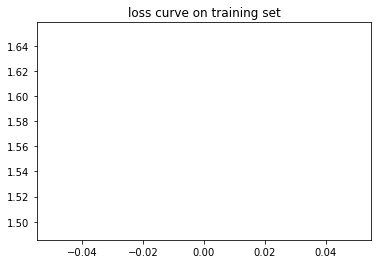

Subexperiment  (0, 0)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    architecture: (2048, 256, 256, 256, 256, 256, 1)
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0.25
    hidden_batchnorm: True
    batch_size: 32
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7f5933366560>
    weight_decay: 0.1
    num_epochs: 1
    loss_function: MSELoss()
    optimiser: <class 'torch.optim.adamw.AdamW'>
    performance_metrics: regression
    print_results_per_epochs: None


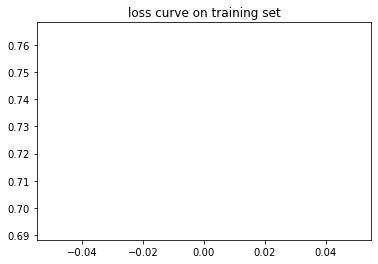

Subexperiment  (0, 1)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    architecture: (2048, 256, 256, 256, 256, 256, 1)
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0.25
    hidden_batchnorm: True
    batch_size: 64
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7f59330c00e0>
    weight_decay: 0.1
    num_epochs: 1
    loss_function: MSELoss()
    optimiser: <class 'torch.optim.adamw.AdamW'>
    performance_metrics: regression
    print_results_per_epochs: None


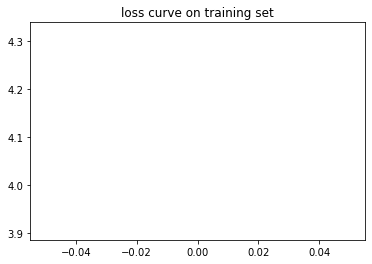

Subexperiment  (1, 0)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    architecture: (2048, 128, 1)
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0.25
    hidden_batchnorm: True
    batch_size: 128
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.001
    lr_lambda: <function <lambda> at 0x7f59330c00e0>
    weight_decay: 0.1
    num_epochs: 1
    loss_function: MSELoss()
    optimiser: <class 'torch.optim.adamw.AdamW'>
    performance_metrics: regression
    print_results_per_epochs: None


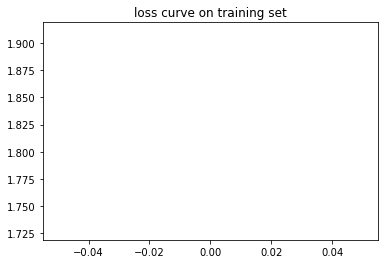

Subexperiment  (1, 1)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    architecture: (2048, 256, 1)
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0.25
    hidden_batchnorm: True
    batch_size: 32
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7f5933366560>
    weight_decay: 0.1
    num_epochs: 1
    loss_function: MSELoss()
    optimiser: <class 'torch.optim.adamw.AdamW'>
    performance_metrics: regression
    print_results_per_epochs: None


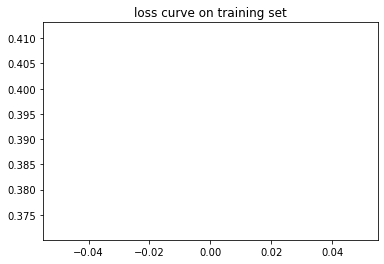

Subexperiment  (2, 0)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    architecture: (2048, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 1)
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0.25
    hidden_batchnorm: True
    batch_size: 32
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.001
    lr_lambda: <function <lambda> at 0x7f59330c00e0>
    weight_decay: 0.01
    num_epochs: 1
    loss_function: MSELoss()
    optimiser: <class 'torch.optim.adamw.AdamW'>
    performance_metrics: regression
    print_results_per_epochs: None


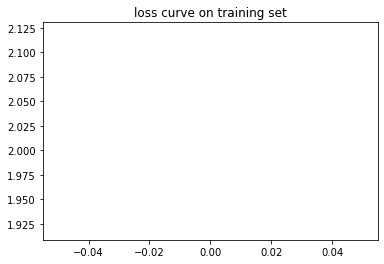

Subexperiment  (2, 1)  completed. 



In [23]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (mols)
    X_fp = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles])
    
    X_fp_train = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles[ind_train_mols]])
    y_train = y[ind_train_mols]
    Y_train = np.reshape(y_train, (-1, 1))
    
    X_fp_test = np.array([x_smiles_to_fp_dict[smiles] for smiles in x_smiles[ind_test_mols]])
    y_test = y[ind_test_mols]
    Y_test = np.reshape(y_test, (-1, 1))
    
    # create pytorch dataset objects for training and testing
    dataset_train = TensorDataset(torch.tensor(X_fp_train, dtype = torch.float), torch.tensor(Y_train, dtype = torch.float))
    dataset_test = TensorDataset(torch.tensor(X_fp_test, dtype = torch.float), torch.tensor(Y_test, dtype = torch.float))
    
    # find best hyperparameters via optuna and train associated model on training set
    (regressor, 
     loss_curve_training_set) = train_mlps_via_optuna(dataset_train,
                                                      settings_dict["optuna_options"],
                                                      settings_dict["mlp_hyperparameter_grid"], 
                                                      settings_dict["train_hyperparameter_grid"])
    
    # plot learning curves
    plt.plot(loss_curve_training_set)
    plt.title("loss curve on training set")
    plt.show()
    
    # create qsar predictions used to evaluate the model
    y_pred = regressor(torch.tensor(X_fp, dtype = torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')).cpu().detach().numpy()[:,0]
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

In [24]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

Experimental Settings: 
 
target_name = postera_sars_cov_2_mpro
n_molecules = 1924
n_mmps = 10832
method_name = ecfp_mlp
 
k_splits = 2
m_reps = 3
random_state_cv = 42
 
radius = 2
bitstring_length = 2048
use_features = False
use_chirality = True
 
optuna_options = {'h_iters': 1, 'frac_train': 0.8, 'data_splitting_seed': 42, 'performance_metric': <function mean_absolute_error at 0x7f5a3e24f7a0>, 'direction': 'minimize', 'sampler': <optuna.samplers._tpe.sampler.TPESampler object at 0x7f59330ba9d0>, 'pruner': <optuna.pruners._nop.NopPruner object at 0x7f59330bab10>}
 
mlp_hyperparameter_grid = {'architecture': [(2048, 64, 1), (2048, 64, 64, 64, 64, 64, 1), (2048, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 1), (2048, 128, 1), (2048, 128, 128, 128, 128, 128, 1), (2048, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 1), (2048, 256, 1), (2048, 256, 256, 256, 256, 256, 1), (2048, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 1), (2048, 512, 1), (2048, 512, 512, 512, 512, 512, 1), (2048, 5

,MAE,MedAE,RMSE,MaxAE,MSE,Pearson's r,R^2,Test Cases
Avg.,1.0634,0.9966,1.2551,3.1399,1.7739,0.5806,-0.6218,962.0
Std.,0.2917,0.2792,0.3125,0.7885,0.7943,0.2131,0.7110,0.0



 

scores_qsar_test 



,MAE,MedAE,RMSE,MaxAE,MSE,Pearson's r,R^2,Test Cases
Avg.,1.0702,0.9917,1.2758,3.4539,1.7939,0.5533,-0.6516,962.0
Std.,0.2803,0.3018,0.2842,1.1362,0.7438,0.1714,0.6995,0.0



 

scores_ac_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5059,0.9535,0.5021,0.0085,0.0241,0.0044,0.9998,0.3333,0.9537,2708.5000,2581.0,127.5000
Std.,0.0221,0.0080,0.0023,0.0085,0.0283,0.0044,0.0002,0.0000,0.0078,173.8333,144.0,29.8333



 

scores_ac_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6634,0.7139,0.6473,0.2591,0.2215,0.5735,0.7211,0.2202,0.9683,5415.0,5149.0,266.0
Std.,0.0538,0.1386,0.0509,0.1258,0.1336,0.0464,0.1481,0.1451,0.0033,0.0,0.0,0.0



 

scores_ac_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5264,0.9533,0.4999,0.0,-0.001,0.0,0.9999,0.0,0.9535,2708.5000,2581.0,127.5000
Std.,0.0379,0.0079,0.0001,0.0,0.001,0.0,0.0001,0.0,0.0080,173.8333,144.0,29.8333



 

scores_ac_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5661,0.9501,0.5,0.0,0.0,0.0,1.0,NaN,0.9501,184.5000,175.5000,9.0
Std.,0.1136,0.0073,0.0,0.0,0.0,0.0,0.0,NaN,0.0073,7.8333,8.1667,1.0



 

scores_pd_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5937,0.5622,0.5629,0.5299,0.1248,0.5695,0.5564,0.4959,0.6277,2708.5000,1531.3333,1177.1667
Std.,0.0467,0.0301,0.0310,0.0353,0.0612,0.0363,0.0257,0.0340,0.0310,173.8333,97.3333,113.5000



 

scores_pd_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6171,0.5587,0.5594,0.5260,0.1178,0.5645,0.5543,0.4926,0.6242,5415.0,3065.3333,2349.6667
Std.,0.0277,0.0218,0.0223,0.0238,0.0443,0.0263,0.0184,0.0218,0.0220,0.0,0.0000,0.0000



 

scores_pd_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5745,0.5501,0.5514,0.5193,0.1019,0.5612,0.5417,0.4839,0.6171,2708.5000,1531.3333,1177.1667
Std.,0.0175,0.0093,0.0099,0.0155,0.0198,0.0143,0.0055,0.0222,0.0258,173.8333,97.3333,113.5000



 

scores_pd_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5440,0.5231,0.5249,0.5122,0.0499,0.5604,0.4893,0.4722,0.5778,184.5000,101.6667,82.8333
Std.,0.0179,0.0230,0.0217,0.0341,0.0436,0.0348,0.0245,0.0330,0.0189,7.8333,9.0000,4.5000



 

scores_pd_ac_pos_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5,0.8333,0.75,0.8889,0.3333,1.0,0.5,0.8333,1.0,1.3333,0.3333,1.0
Std.,0.0,0.0000,0.00,0.0000,0.0000,0.0,0.0,0.0000,0.0,1.3333,0.3333,1.0



 

scores_pd_ac_pos_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.7966,0.7127,0.7244,0.6708,0.4374,0.7633,0.6856,0.6127,0.8142,1595.0000,976.0,619.0000
Std.,0.0864,0.1012,0.0954,0.1256,0.1976,0.0903,0.1004,0.1738,0.0765,774.3333,446.0,328.3333



 

scores_pd_ac_pos_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.3333,0.1667,0.1667
Std.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3333,0.1667,0.1667



 

scores_pd_ac_pos_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
Std.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


## PDV + RF

In [21]:
# set directory for saving of experimental results

settings_dict["method_name"] = "pdv_rf"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [26]:
# hyperparameter- and random search settings

settings_dict["j_splits"] = 5
settings_dict["h_iters"] = 10
settings_dict["random_search_scoring"] = "neg_mean_absolute_error"
settings_dict["random_search_verbose"] = 1
settings_dict["random_search_random_state"] = 42
settings_dict["random_search_n_jobs"] = -1
settings_dict["hyperparameter_grid"] = {"n_estimators": [500], 
                                        "max_depth": [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, None],
                                        "min_samples_split": [2, 4, 6, 8, 10, 12],
                                        "min_samples_leaf": [1, 2, 3, 4, 5, 6],
                                        "max_features": ["auto", "sqrt", "log2"],
                                        "bootstrap": [True, False],
                                        "random_state": [42]}

In [27]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (mols)        
    X_pdv_train = X_pdv[ind_train_mols]
    y_train = y[ind_train_mols]
    
    X_pdv_test = X_pdv[ind_test_mols]
    y_test = y[ind_test_mols]
    
    # normalise data with empirical cumulative distribution functions for each feature (ecdf derived from training set)
    (X_pdv_norm_train, normalisation_function) = normaliser_cdf(X_pdv_train)
    X_pdv_norm_test = normalisation_function(X_pdv_test)
    X_pdv_norm = normalisation_function(X_pdv)
    
    # instantiate fresh model
    regressor = RandomizedSearchCV(estimator = RandomForestRegressor(),
                                   param_distributions = settings_dict["hyperparameter_grid"],
                                   n_iter = settings_dict["h_iters"],
                                   cv = settings_dict["j_splits"],
                                   scoring = settings_dict["random_search_scoring"],
                                   verbose = settings_dict["random_search_verbose"],
                                   random_state = settings_dict["random_search_random_state"],
                                   n_jobs = settings_dict["random_search_n_jobs"])

    # fit the model on the training data
    regressor.fit(X_pdv_norm_train, y_train)
    
    # create qsar predictions used to evaluate the model
    y_pred = regressor.predict(X_pdv_norm)
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (0, 0)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (0, 1)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (1, 0)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (1, 1)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (2, 0)  completed. 

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (2, 1)  completed. 



In [22]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

Experimental Settings: 
 
target_name = postera_sars_cov_2_mpro
n_molecules = 1924
n_mmps = 10832
method_name = pdv_rf
 
k_splits = 2
m_reps = 3
random_state_cv = 42
 
descriptor_list = None
 
j_splits = 5
h_iters = 10
random_search_scoring = neg_mean_absolute_error
random_search_verbose = 1
random_search_random_state = 42
random_search_n_jobs = -1
hyperparameter_grid = {'n_estimators': [500], 'max_depth': [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, None], 'min_samples_split': [2, 4, 6, 8, 10, 12], 'min_samples_leaf': [1, 2, 3, 4, 5, 6], 'max_features': ['auto', 'sqrt', 'log2'], 'bootstrap': [True, False], 'random_state': [42]}
 
runtime = 00:04:13
 

scores_qsar_train 



,MAE,MedAE,RMSE,MaxAE,MSE,Pearson's r,R^2,Test Cases
Avg.,0.2821,0.1896,0.4059,2.3000,0.1703,0.9247,0.8440,962.0
Std.,0.0549,0.0439,0.0609,0.4159,0.0478,0.0217,0.0431,0.0



 

scores_qsar_test 



,MAE,MedAE,RMSE,MaxAE,MSE,Pearson's r,R^2,Test Cases
Avg.,0.5153,0.3797,0.6871,3.2867,0.4724,0.7541,0.5667,962.0
Std.,0.0066,0.0086,0.0138,0.5611,0.0189,0.0083,0.0124,0.0



 

scores_ac_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.9449,0.9673,0.6378,0.3233,0.3653,0.2758,0.9999,0.9949,0.9673,2708.5000,2581.0,127.5000
Std.,0.0194,0.0157,0.1309,0.2966,0.2982,0.2619,0.0001,0.0000,0.0157,173.8333,144.0,29.8333



 

scores_ac_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.9121,0.9595,0.7023,0.4933,0.4866,0.4171,0.9875,0.6222,0.9704,5415.0,5149.0,266.0
Std.,0.0150,0.0056,0.0523,0.1008,0.0959,0.1041,0.0021,0.0688,0.0051,0.0,0.0,0.0



 

scores_ac_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.7328,0.9527,0.5036,0.0164,0.0399,0.0086,0.9987,0.3869,0.9538,2708.5000,2581.0,127.5000
Std.,0.0830,0.0081,0.0021,0.0064,0.0286,0.0032,0.0010,0.2798,0.0079,173.8333,144.0,29.8333



 

scores_ac_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5161,0.9499,0.5071,0.0278,0.0473,0.0152,0.999,0.5,0.9508,184.5000,175.5000,9.0
Std.,0.0838,0.0069,0.0081,0.0278,0.0507,0.0152,0.001,0.0,0.0078,7.8333,8.1667,1.0



 

scores_pd_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.8535,0.7715,0.7776,0.7567,0.5495,0.8192,0.7360,0.7039,0.8400,2708.5000,1531.3333,1177.1667
Std.,0.0412,0.0318,0.0350,0.0286,0.0668,0.0478,0.0265,0.0303,0.0493,173.8333,97.3333,113.5000



 

scores_pd_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.7497,0.6839,0.6875,0.6625,0.3718,0.7152,0.6599,0.6171,0.7514,5415.0,3065.3333,2349.6667
Std.,0.0044,0.0067,0.0070,0.0075,0.0138,0.0085,0.0054,0.0066,0.0070,0.0,0.0000,0.0000



 

scores_pd_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6606,0.6129,0.6162,0.5887,0.2301,0.6398,0.5926,0.5458,0.6821,2708.5000,1531.3333,1177.1667
Std.,0.0053,0.0041,0.0027,0.0137,0.0066,0.0033,0.0062,0.0240,0.0162,173.8333,97.3333,113.5000



 

scores_pd_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5782,0.5550,0.5545,0.5216,0.1082,0.5440,0.5651,0.5038,0.6036,184.5000,101.6667,82.8333
Std.,0.0426,0.0318,0.0336,0.0295,0.0661,0.0528,0.0144,0.0172,0.0568,7.8333,9.0000,4.5000



 

scores_pd_ac_pos_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,1.0,0.9975,0.997,0.9978,0.9948,1.0,0.9939,0.9957,1.0,37.3333,15.8333,21.5000
Std.,0.0,0.0000,0.000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,36.3333,15.5000,20.8333



 

scores_pd_ac_pos_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.9312,0.9252,0.9251,0.9295,0.8504,0.9335,0.9168,0.9260,0.9246,175.1667,82.6667,92.5
Std.,0.0330,0.0385,0.0382,0.0361,0.0768,0.0382,0.0382,0.0337,0.0434,25.5000,12.0000,13.5



 

scores_pd_ac_pos_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.8625,0.9107,0.8250,0.8939,0.5410,0.9375,0.775,0.8583,0.9444,4.6667,2.1667,2.5
Std.,0.0250,0.0893,0.0625,0.1061,0.2183,0.0625,0.125,0.1417,0.0000,2.3333,1.8333,0.5



 

scores_pd_ac_pos_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,NaN,0.5,NaN,0.0,0.0,NaN,0.5,0.0,1.0,0.3333,0.3333,0.0
Std.,NaN,0.0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.3333,0.3333,0.0


## PDV + kNN

In [15]:
# set directory for saving of experimental results

settings_dict["method_name"] = "pdv_knn"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [33]:
# hyperparameter- and random search settings

settings_dict["j_splits"] = 5
settings_dict["h_iters"] = 10
settings_dict["random_search_scoring"] = "neg_mean_absolute_error"
settings_dict["random_search_verbose"] = 1
settings_dict["random_search_random_state"] = 42
settings_dict["random_search_n_jobs"] = -1
settings_dict["hyperparameter_grid"] = {"n_neighbors": list(range(1, 101)),
                                        "weights": ["uniform", "distance"],
                                        "p": [1, 2, 3]}

In [34]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (mols)        
    X_pdv_train = X_pdv[ind_train_mols]
    y_train = y[ind_train_mols]
    
    X_pdv_test = X_pdv[ind_test_mols]
    y_test = y[ind_test_mols]
    
    # normalise data with empirical cumulative distribution functions for each feature (ecdf derived from training set)
    (X_pdv_norm_train, normalisation_function) = normaliser_cdf(X_pdv_train)
    X_pdv_norm_test = normalisation_function(X_pdv_test)
    X_pdv_norm = normalisation_function(X_pdv)
    
     # instantiate fresh model
    regressor = RandomizedSearchCV(estimator = KNeighborsRegressor(),
                                   param_distributions = settings_dict["hyperparameter_grid"],
                                   n_iter = settings_dict["h_iters"],
                                   cv = settings_dict["j_splits"],
                                   scoring = settings_dict["random_search_scoring"],
                                   verbose = settings_dict["random_search_verbose"],
                                   random_state = settings_dict["random_search_random_state"],
                                   n_jobs = settings_dict["random_search_n_jobs"])

    # fit the model on the training data
    regressor.fit(X_pdv_norm_train, y_train)
    
    # create qsar predictions used to evaluate the model
    y_pred = regressor.predict(X_pdv_norm)
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Subexperiment  (0, 0)  completed. 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Subexperiment  (0, 1)  completed. 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Subexperiment  (1, 0)  completed. 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Subexperiment  (1, 1)  completed. 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Subexperiment  (2, 0)  completed. 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Subexperiment  (2, 1)  completed. 



In [16]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

Experimental Settings: 
 
target_name = chembl_dopamine_d2
n_molecules = 6333
n_mmps = 31680
method_name = pdv_knn
 
k_splits = 2
m_reps = 3
random_state_cv = 42
 
descriptor_list = None
 
j_splits = 5
h_iters = 10
random_search_scoring = neg_mean_absolute_error
random_search_verbose = 1
random_search_random_state = 42
random_search_n_jobs = -1
hyperparameter_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3]}
 
runtime = 00:04:23
 

scores_qsar_train 



,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Avg.,0.2090,0.1438,0.3156,2.2704,0.1249,0.9381,0.8816,3166.5
Std.,0.0974,0.0721,0.1124,0.3677,0.0583,0.0289,0.0552,0.5



 

scores_qsar_test 



,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Avg.,0.5675,0.4265,0.7632,4.3137,0.5825,0.6870,0.4475,3166.5
Std.,0.0062,0.0106,0.0069,0.5425,0.0105,0.0078,0.0022,0.5



 

scores_ac_train 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.9346,0.9920,0.8150,0.6675,0.6662,0.6331,0.9969,0.7127,0.9950,7905.6667,7792.6667,113.0000
Std.,0.0363,0.0037,0.0934,0.1630,0.1632,0.1856,0.0013,0.1348,0.0025,227.0000,228.0000,7.6667



 

scores_ac_inter 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.8873,0.9777,0.6909,0.3460,0.3378,0.3954,0.9865,0.3085,0.9909,15868.6667,15633.6667,235.0
Std.,0.0251,0.0020,0.0144,0.0358,0.0358,0.0271,0.0017,0.0404,0.0004,0.0000,0.0000,0.0



 

scores_ac_test 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.6913,0.9755,0.5492,0.1112,0.1051,0.1105,0.9880,0.1372,0.9871,7905.6667,7792.6667,113.0000
Std.,0.0272,0.0047,0.0168,0.0245,0.0216,0.0379,0.0044,0.0359,0.0006,227.0000,228.0000,7.6667



 

scores_ac_cores 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.6133,0.9611,0.5176,0.0473,0.0369,0.0580,0.9772,0.0697,0.9832,1004.1667,986.6667,17.5000
Std.,0.0110,0.0098,0.0156,0.0337,0.0385,0.0277,0.0104,0.0609,0.0035,28.5000,31.6667,4.1667



 

scores_pd_train 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.8798,0.8306,0.8305,0.8245,0.6617,0.8079,0.8530,0.8421,0.8204,7905.6667,3961.5000,3944.1667
Std.,0.0635,0.0803,0.0803,0.0833,0.1602,0.0909,0.0697,0.0751,0.0847,227.0000,117.8333,110.8333



 

scores_pd_inter 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.7525,0.6983,0.6984,0.6961,0.3967,0.6997,0.6971,0.6926,0.7041,15868.6667,8033.0,7835.6667
Std.,0.0109,0.0076,0.0076,0.0073,0.0151,0.0064,0.0087,0.0081,0.0070,0.0000,0.0,0.0000



 

scores_pd_test 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.6114,0.5815,0.5815,0.5662,0.1635,0.5474,0.6156,0.5869,0.5772,7905.6667,3961.5000,3944.1667
Std.,0.0072,0.0038,0.0040,0.0033,0.0083,0.0109,0.0179,0.0095,0.0012,227.0000,117.8333,110.8333



 

scores_pd_cores 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.5848,0.5594,0.5592,0.5148,0.1205,0.4717,0.6467,0.5717,0.5509,1004.1667,500.1667,504.0
Std.,0.0137,0.0156,0.0150,0.0380,0.0289,0.0576,0.0285,0.0099,0.0179,28.5000,13.8333,19.0



 

scores_pd_ac_pos_train 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.9840,0.9756,0.9747,0.9767,0.9521,0.9846,0.9649,0.9699,0.9848,98.0000,48.8333,49.1667
Std.,0.0084,0.0173,0.0183,0.0162,0.0340,0.0154,0.0273,0.0222,0.0152,17.3333,9.8333,7.5000



 

scores_pd_ac_pos_inter 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.8935,0.874,0.8736,0.8786,0.7474,0.8851,0.8620,0.8724,0.8753,304.0,148.0000,156.0000
Std.,0.0236,0.023,0.0233,0.0241,0.0463,0.0185,0.0298,0.0315,0.0194,21.0,14.3333,8.3333



 

scores_pd_ac_pos_test 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.7414,0.7209,0.7214,0.7259,0.4450,0.7569,0.6858,0.6996,0.7476,105.6667,53.5,52.1667
Std.,0.0678,0.0385,0.0388,0.0490,0.0799,0.0724,0.0323,0.0296,0.0528,40.0000,20.5,19.5000



 

scores_pd_ac_pos_cores 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.6812,0.6317,0.6597,0.6664,0.3514,0.8421,0.4773,0.5762,0.8197,23.5,12.6667,10.8333
Std.,0.0720,0.0654,0.0408,0.0740,0.0634,0.0554,0.1371,0.1175,0.0591,9.5,5.0000,4.5000


## PDV + MLP

In [33]:
# set directory for saving of experimental results

settings_dict["method_name"] = "pdv_mlp"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [28]:
# hyperparameter- and optuna options

settings_dict["optuna_options"] = {"h_iters": 20,
                                   "frac_train": 0.8,
                                   "data_splitting_seed": 42,
                                   "performance_metric": mean_absolute_error,
                                   "direction": "minimize",
                                   "sampler": optuna.samplers.TPESampler(), 
                                   "pruner": optuna.pruners.NopPruner()} 

settings_dict["mlp_hyperparameter_grid"] = {"architecture": [arch(200, 1, w, d) for (w,d) in all_combs_list([64, 128, 256, 512], [1, 5, 10])],
                                          "hidden_activation": [nn.ReLU()],
                                          "output_activation": [nn.Identity()],
                                          "use_bias": [True],
                                          "hidden_dropout_rate": [0, 0.25],
                                          "hidden_batchnorm": [True]}

settings_dict["train_hyperparameter_grid"] = {"batch_size": [32, 64, 128],
                                              "dataloader_shuffle": [True],
                                              "dataloader_drop_last":[True],
                                              "learning_rate": [1e-2, 1e-3],
                                              "lr_lambda": [lambda epoch: max(0.95**epoch, 1e-2), lambda epoch: max(0.99**epoch, 1e-2)],
                                              "weight_decay": [0.1, 0.01],
                                              "num_epochs": [500],
                                              "loss_function": [nn.MSELoss()],
                                              "optimiser": [torch.optim.AdamW],
                                              "performance_metrics": ["regression"],
                                              "print_results_per_epochs": [None]}

In [30]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (mols)        
    X_pdv_train = X_pdv[ind_train_mols]
    y_train = y[ind_train_mols]
    Y_train = np.reshape(y_train, (-1, 1))
    
    X_pdv_test = X_pdv[ind_test_mols]
    y_test = y[ind_test_mols]
    Y_test = np.reshape(y_test, (-1, 1))
    
    # normalise data with empirical cumulative distribution functions for each feature (ecdf derived from training set)
    (X_pdv_norm_train, normalisation_function) = normaliser_cdf(X_pdv_train)
    X_pdv_norm_test = normalisation_function(X_pdv_test)
    X_pdv_norm = normalisation_function(X_pdv)
    
    # create pytorch dataset objects for training and testing
    dataset_train = TensorDataset(torch.tensor(X_pdv_norm_train, dtype = torch.float), torch.tensor(Y_train, dtype = torch.float))
    dataset_test = TensorDataset(torch.tensor(X_pdv_norm_test, dtype = torch.float), torch.tensor(Y_test, dtype = torch.float))
    
    # find best hyperparameters via optuna and train associated model on training set
    (regressor, 
     loss_curve_training_set) = train_mlps_via_optuna(dataset_train,
                                                      settings_dict["optuna_options"],
                                                      settings_dict["mlp_hyperparameter_grid"], 
                                                      settings_dict["train_hyperparameter_grid"])
    # plot learning curves
    plt.plot(loss_curve_training_set)
    plt.title("loss curve on training set")
    plt.show()
    
    # create qsar predictions used to evaluate the model
    y_pred = regressor(torch.tensor(X_pdv_norm, dtype = torch.float).to('cuda' if torch.cuda.is_available() else 'cpu')).cpu().detach().numpy()[:,0]
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

NameError: name 'TensorDataset' is not defined

In [35]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

Experimental Settings: 
 
target_name = postera_sars_cov_2_mpro
n_molecules = 1924
n_mmps = 10832
method_name = pdv_mlp
 
k_splits = 2
m_reps = 3
random_state_cv = 42
 
descriptor_list = None
 
optuna_options = {'h_iters': 1, 'frac_train': 0.8, 'data_splitting_seed': 42, 'performance_metric': <function mean_absolute_error at 0x7f6bfcd7e560>, 'direction': 'minimize', 'sampler': <optuna.samplers._tpe.sampler.TPESampler object at 0x7f6af1aeff50>, 'pruner': <optuna.pruners._nop.NopPruner object at 0x7f6af1aefc90>}
 
mlp_hyperparameter_grid = {'architecture': [(200, 64, 1), (200, 64, 64, 64, 64, 64, 1), (200, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 1), (200, 128, 1), (200, 128, 128, 128, 128, 128, 1), (200, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 1), (200, 256, 1), (200, 256, 256, 256, 256, 256, 1), (200, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 1), (200, 512, 1), (200, 512, 512, 512, 512, 512, 1), (200, 512, 512, 512, 512, 512, 512, 512, 512, 512, 512, 1)], 'hidden_activ

,MAE,MedAE,RMSE,MaxAE,MSE,Pearson's r,R^2,Test Cases
Avg.,1.7289,1.6852,1.995,4.4399,4.8604,0.5207,-3.4583,962.0
Std.,0.1556,0.2736,0.088,1.0328,0.5204,0.0618,0.4882,0.0



 

scores_qsar_test 



,MAE,MedAE,RMSE,MaxAE,MSE,Pearson's r,R^2,Test Cases
Avg.,1.7149,1.6339,1.9847,4.287,4.8622,0.5061,-3.4578,962.0
Std.,0.1569,0.2786,0.0717,0.900,0.4457,0.0638,0.4010,0.0



 

scores_ac_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.4688,0.9256,0.4938,0.0087,-0.0054,0.0169,0.9707,0.0305,0.9531,2708.5000,2581.0,127.5000
Std.,0.0251,0.0207,0.0065,0.0087,0.0064,0.0169,0.0293,0.0000,0.0076,173.8333,144.0,29.8333



 

scores_ac_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5254,0.4649,0.5289,0.1030,0.0234,0.6001,0.4576,0.0574,0.9495,5415.0,5149.0,266.0
Std.,0.0218,0.0314,0.0074,0.0038,0.0073,0.0267,0.0345,0.0025,0.0037,0.0,0.0,0.0



 

scores_ac_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.4624,0.9174,0.486,0.0049,-0.0189,0.0112,0.9608,0.0093,0.9515,2708.5000,2581.0,127.5000
Std.,0.0146,0.0442,0.014,0.0049,0.0189,0.0112,0.0392,0.0000,0.0100,173.8333,144.0,29.8333



 

scores_ac_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.4436,0.9371,0.4931,0.0,-0.0155,0.0,0.9862,0.0,0.9493,184.5000,175.5000,9.0
Std.,0.0638,0.0084,0.0069,0.0,0.0155,0.0,0.0138,0.0,0.0065,7.8333,8.1667,1.0



 

scores_pd_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5452,0.5256,0.5256,0.4901,0.0508,0.5266,0.5246,0.4589,0.5915,2708.5000,1531.3333,1177.1667
Std.,0.0351,0.0215,0.0225,0.0303,0.0445,0.0297,0.0152,0.0365,0.0228,173.8333,97.3333,113.5000



 

scores_pd_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5686,0.5211,0.5221,0.4896,0.0438,0.5294,0.5148,0.4554,0.5879,5415.0,3065.3333,2349.6667
Std.,0.0078,0.0173,0.0171,0.0166,0.0339,0.0160,0.0182,0.0169,0.0167,0.0,0.0000,0.0000



 

scores_pd_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5585,0.5366,0.5367,0.5007,0.0728,0.5364,0.5370,0.4703,0.6019,2708.5000,1531.3333,1177.1667
Std.,0.0140,0.0126,0.0126,0.0224,0.0253,0.0134,0.0118,0.0315,0.0173,173.8333,97.3333,113.5000



 

scores_pd_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5204,0.5255,0.5253,0.4966,0.050,0.5222,0.5285,0.4751,0.5743,184.5000,101.6667,82.8333
Std.,0.0442,0.0284,0.0282,0.0150,0.056,0.0278,0.0343,0.0073,0.0517,7.8333,9.0000,4.5000



 

scores_pd_ac_pos_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6805,0.6696,0.6672,0.6941,0.3379,0.7238,0.6106,0.6674,0.674,71.6667,34.5,37.1667
Std.,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,71.6667,34.5,37.1667



 

scores_pd_ac_pos_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6465,0.5762,0.5866,0.5235,0.1620,0.6150,0.5582,0.4651,0.6867,2953.6667,1739.5000,1214.1667
Std.,0.0067,0.0041,0.0069,0.0334,0.0046,0.0206,0.0106,0.0597,0.0540,185.6667,89.8333,187.1667



 

scores_pd_ac_pos_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6519,0.6545,0.6737,0.5651,0.3103,0.6977,0.6497,0.5135,0.7669,110.8333,52.8333,58.0
Std.,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,110.8333,52.8333,58.0



 

scores_pd_ac_pos_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5667,0.697,0.6167,0.3636,0.2333,0.3333,0.9,0.8,0.6667,2.3333,1.1667,1.1667
Std.,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0000,2.3333,1.1667,1.1667


## GIN + RF

In [19]:
# set directory for saving of experimental results

settings_dict["method_name"] = "gin_rf"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [42]:
# GNN + MLP: hyperparameter- and optuna settings

settings_dict["optuna_options"] = {"h_iters": 20,
                                   "frac_train": 0.8,
                                   "data_splitting_seed": 42,
                                   "performance_metric": mean_absolute_error,
                                   "direction": "minimize",
                                   "sampler": optuna.samplers.TPESampler(), 
                                   "pruner": optuna.pruners.NopPruner()} 

settings_dict["gin_hyperparameter_grid"] = {"n_conv_layers": [1, 2, 3],
                                            "input_dim": [79],
                                            "hidden_dim": [64, 128, 256],
                                            "mlp_n_hidden_layers": [2],
                                            "mlp_hidden_activation": [nn.ReLU()],
                                            "mlp_output_activation": [nn.Identity()],
                                            "mlp_use_bias": [True],
                                            "mlp_hidden_dropout_rate": [0, 0.25],
                                            "mlp_hidden_batchnorm": [True],
                                            "eps": [0],
                                            "train_eps": [False],
                                            "pooling_operation": [global_max_pool]}

settings_dict["mlp_hyperparameter_grid"] = {"architecture": [arch(None, 1, w, d) for (w,d) in all_combs_list([None], [0])],
                                            "hidden_activation": [nn.ReLU()],
                                            "output_activation": [nn.Identity()],
                                            "use_bias": [True],
                                            "hidden_dropout_rate": [0],
                                            "hidden_batchnorm": [True]}

settings_dict["train_hyperparameter_grid"] = {"batch_size": [32, 64, 128], 
                                              "dataloader_shuffle": [True],
                                              "dataloader_drop_last":[True],
                                              "learning_rate": [1e-2, 1e-3],
                                              "lr_lambda": [lambda epoch: max(0.95**epoch, 1e-2), lambda epoch: max(0.99**epoch, 1e-2)],
                                              "weight_decay": [0.1, 0.01],
                                              "num_epochs": [500],
                                              "loss_function": [nn.MSELoss()],
                                              "optimiser": [torch.optim.AdamW],
                                              "performance_metrics": ["regression"],
                                              "print_results_per_epochs": [None]}

In [43]:
# RF: hyperparameter- and random search settings

settings_dict["j_splits"] = 5
settings_dict["h_iters"] = 10
settings_dict["random_search_scoring"] = "neg_mean_absolute_error"
settings_dict["random_search_verbose"] = 1
settings_dict["random_search_random_state"] = 42
settings_dict["random_search_n_jobs"] = -1
settings_dict["hyperparameter_grid"] = {"n_estimators": [500], 
                                        "max_depth": [30, 40, 50, 60, 70, 80, 90, 100, 110, 120, None],
                                        "min_samples_split": [2, 4, 6, 8, 10, 12],
                                        "min_samples_leaf": [1, 2, 3, 4, 5, 6],
                                        "max_features": ["auto", "sqrt", "log2"],
                                        "bootstrap": [True, False],
                                        "random_state": [42]}

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 256
    architecture: (None, 1)
    n_conv_layers: 2
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0.25
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7fce6092f440>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 128
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.001
    lr_lambda: <function <lambda> at 0x7fce3c210830>
    weight_decay: 0.01
    num_epochs: 1
    loss_function: MSELoss()
    optimiser: <class 'torch.optim.adamw.AdamW'>
    performance_metrics: regression
    print_results_p

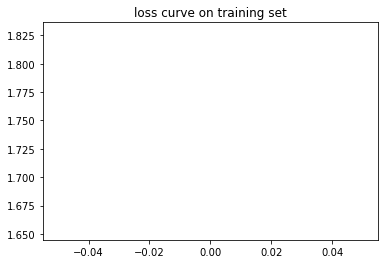

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (0, 0)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 256
    architecture: (None, 1)
    n_conv_layers: 3
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7fce6092f440>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 64
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.001
    lr_lambda: <function <lambda> at 0x7fce3c210830>
    weight_decay: 0.1
    num_epochs: 1
    loss_function: MSELoss()
    optimiser:

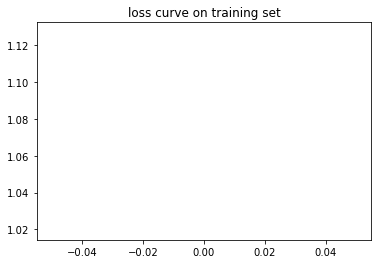

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (0, 1)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 128
    architecture: (None, 1)
    n_conv_layers: 2
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7fce6092f440>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 32
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.001
    lr_lambda: <function <lambda> at 0x7fce3c210710>
    weight_decay: 0.01
    num_epochs: 1
    loss_function: MSELoss()
    optimiser

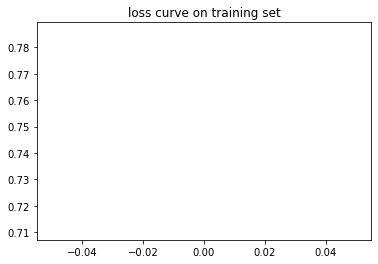

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (1, 0)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 128
    architecture: (None, 1)
    n_conv_layers: 2
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7fce6092f440>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 128
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.001
    lr_lambda: <function <lambda> at 0x7fce3c210710>
    weight_decay: 0.1
    num_epochs: 1
    loss_function: MSELoss()
    optimiser

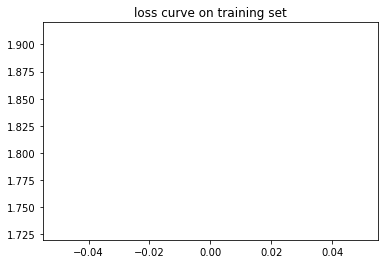

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (1, 1)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 64
    architecture: (None, 1)
    n_conv_layers: 2
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7fce6092f440>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 128
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7fce3c210710>
    weight_decay: 0.1
    num_epochs: 1
    loss_function: MSELoss()
    optimiser: 

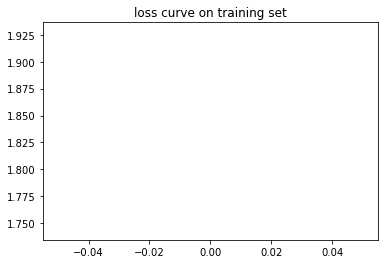

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (2, 0)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 256
    architecture: (None, 1)
    n_conv_layers: 1
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7fce6092f440>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 128
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7fce3c210830>
    weight_decay: 0.01
    num_epochs: 1
    loss_function: MSELoss()
    optimiser

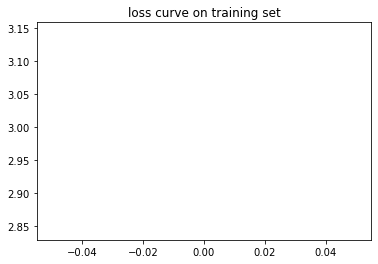

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (2, 1)  completed. 



In [44]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (GNN + MLP)
    graph_list_train = [graph_list[k] for k in ind_train_mols]
    graph_list_test = [graph_list[k] for k in ind_test_mols]
    
    # find best hyperparameters via optuna and train associated model on training set (GNN + MLP)
    (trained_best_gnn_model, 
     trained_best_mlp_model, 
     loss_curve_training_set) = train_gnn_mlps_via_optuna(graph_list_train,
                                                          settings_dict["optuna_options"],
                                                          settings_dict["gin_hyperparameter_grid"], 
                                                          settings_dict["mlp_hyperparameter_grid"], 
                                                          settings_dict["train_hyperparameter_grid"])
    # plot learning curves (GNN + MLP)
    plt.plot(loss_curve_training_set)
    plt.title("loss curve on training set")
    plt.show()
    
    # extract learned features from molecular graphs via GNN
    dataloader = GeometricDataLoader(dataset = graph_list, batch_size = len(graph_list), shuffle = False, drop_last = False)
    trained_best_gnn_model.eval()
    for batch in dataloader:
        X_gnn = trained_best_gnn_model(batch.to('cuda' if torch.cuda.is_available() else 'cpu')).cpu().detach().numpy()
           
    # generate training- and test data       
    X_gnn_train = X_gnn[ind_train_mols]
    y_train = y[ind_train_mols]
    
    X_gnn_test = X_gnn[ind_test_mols]
    y_test = y[ind_test_mols]
    
    # instantiate fresh model
    regressor = RandomizedSearchCV(estimator = RandomForestRegressor(),
                                   param_distributions = settings_dict["hyperparameter_grid"],
                                   n_iter = settings_dict["h_iters"],
                                   cv = settings_dict["j_splits"],
                                   scoring = settings_dict["random_search_scoring"],
                                   verbose = settings_dict["random_search_verbose"],
                                   random_state = settings_dict["random_search_random_state"],
                                   n_jobs = settings_dict["random_search_n_jobs"])

    # fit the model on the training data
    regressor.fit(X_gnn_train, y_train)
    
    # create qsar predictions used to evaluate the model
    y_pred = regressor.predict(X_gnn)
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

In [20]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

Experimental Settings: 
 
target_name = chembl_dopamine_d2
n_molecules = 6333
n_mmps = 31680
method_name = gin_rf
 
k_splits = 2
m_reps = 3
random_state_cv = 42
 
optuna_options = {'h_iters': 20, 'frac_train': 0.8, 'data_splitting_seed': 42, 'performance_metric': <function mean_absolute_error at 0x7fd768d854d0>, 'direction': 'minimize', 'sampler': <optuna.samplers._tpe.sampler.TPESampler object at 0x7fd8258a59d0>, 'pruner': <optuna.pruners._nop.NopPruner object at 0x7fd65bc05450>}
 
mlp_hyperparameter_grid = {'architecture': [(None, 1)], 'hidden_activation': [ReLU()], 'output_activation': [Identity()], 'use_bias': [True], 'hidden_dropout_rate': [0], 'hidden_batchnorm': [True]}
 
gin_hyperparameter_grid = {'n_conv_layers': [1, 2, 3], 'input_dim': [79], 'hidden_dim': [64, 128, 256], 'mlp_n_hidden_layers': [2], 'mlp_hidden_activation': [ReLU()], 'mlp_output_activation': [Identity()], 'mlp_use_bias': [True], 'mlp_hidden_dropout_rate': [0, 0.25], 'mlp_hidden_batchnorm': [True], 'eps': [0], 

,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Avg.,0.1017,0.0684,0.1514,1.5323,0.0243,0.9908,0.9771,3166.5
Std.,0.0153,0.0108,0.0209,0.2618,0.0072,0.0031,0.0067,0.5



 

scores_qsar_test 



,MAE,MedAE,RMSE,MaxAE,MSE,PearsonCorr,R2Coeff,Test Cases
Avg.,0.4685,0.3508,0.6307,3.7086,0.3979,0.7933,0.6224,3166.5
Std.,0.0055,0.0025,0.0085,0.1117,0.0108,0.0062,0.0098,0.5



 

scores_ac_train 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.9969,0.9988,0.9541,0.9496,0.9512,0.9081,1.0,1.0,0.9988,7905.6667,7792.6667,113.0000
Std.,0.0031,0.0007,0.0293,0.0334,0.0317,0.0585,0.0,0.0,0.0007,227.0000,228.0000,7.6667



 

scores_ac_inter 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.9523,0.9885,0.7328,0.5469,0.5493,0.4692,0.9963,0.6567,0.9920,15868.6667,15633.6667,235.0
Std.,0.0065,0.0010,0.0205,0.0432,0.0433,0.0407,0.0004,0.0442,0.0006,0.0000,0.0000,0.0



 

scores_ac_test 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.8177,0.9861,0.5489,0.1689,0.2402,0.0987,0.9990,0.6111,0.9870,7905.6667,7792.6667,113.0000
Std.,0.0161,0.0016,0.0115,0.0381,0.0501,0.0226,0.0005,0.1465,0.0014,227.0000,228.0000,7.6667



 

scores_ac_cores 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.7298,0.9822,0.5444,0.1443,0.1985,0.0909,0.9979,0.5139,0.9842,1004.1667,986.6667,17.5000
Std.,0.0455,0.0033,0.0148,0.0392,0.0439,0.0300,0.0011,0.2361,0.0038,28.5000,31.6667,4.1667



 

scores_pd_train 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.9831,0.9390,0.9390,0.9390,0.8781,0.9402,0.9378,0.9377,0.9403,7905.6667,3961.5000,3944.1667
Std.,0.0074,0.0142,0.0142,0.0142,0.0284,0.0134,0.0150,0.0151,0.0133,227.0000,117.8333,110.8333



 

scores_pd_inter 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.7987,0.7354,0.7355,0.7336,0.4709,0.7379,0.7331,0.7295,0.7414,15868.6667,8033.0,7835.6667
Std.,0.0062,0.0058,0.0058,0.0053,0.0116,0.0060,0.0078,0.0068,0.0050,0.0000,0.0,0.0000



 

scores_pd_test 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.6522,0.6099,0.6099,0.6092,0.2199,0.6093,0.6106,0.6091,0.6108,7905.6667,3961.5000,3944.1667
Std.,0.0107,0.0103,0.0104,0.0102,0.0207,0.0118,0.0104,0.0101,0.0133,227.0000,117.8333,110.8333



 

scores_pd_cores 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.6544,0.6026,0.6026,0.6028,0.2052,0.6013,0.6039,0.6044,0.6008,1004.1667,500.1667,504.0
Std.,0.0090,0.0092,0.0091,0.0135,0.0182,0.0147,0.0095,0.0123,0.0118,28.5000,13.8333,19.0



 

scores_pd_ac_pos_train 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,103.3333,49.1667,54.1667
Std.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0000,9.5000,6.5000



 

scores_pd_ac_pos_inter 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.9670,0.9571,0.9575,0.9596,0.9141,0.9516,0.9633,0.9678,0.9454,167.5000,78.0,89.5000
Std.,0.0173,0.0182,0.0184,0.0173,0.0367,0.0167,0.0200,0.0179,0.0188,8.1667,3.0,5.1667



 

scores_pd_ac_pos_test 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.9532,0.9413,0.9403,0.9381,0.8840,0.9398,0.9409,0.9419,0.9459,18.3333,9.8333,8.5000
Std.,0.0218,0.0227,0.0272,0.0315,0.0437,0.0324,0.0221,0.0278,0.0238,1.6667,1.1667,1.8333



 

scores_pd_ac_pos_cores 



,ROC-AUC,Acc.,Bal. Acc.,F1,MCC,Sens.,Spec.,Pos. Pred. Val.,Neg. Pred. Val.,Test Cases,Neg. Test Cases,Pos. Test Cases
Avg.,0.8056,0.9028,0.8750,0.5873,0.4167,1.0,0.7500,0.8750,1.0,3.6667,2.0,1.6667
Std.,0.0278,0.0139,0.0417,0.3651,0.4167,0.0,0.0833,0.0417,0.0,1.0000,1.0,1.3333


## GIN + kNN

In [21]:
# set directory for saving of experimental results

settings_dict["method_name"] = "gin_knn"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [23]:
# GNN + MLP: hyperparameter- and optuna settings

settings_dict["optuna_options"] = {"h_iters": 20,
                                   "frac_train": 0.8,
                                   "data_splitting_seed": 42,
                                   "performance_metric": mean_absolute_error,
                                   "direction": "minimize",
                                   "sampler": optuna.samplers.TPESampler(), 
                                   "pruner": optuna.pruners.NopPruner()} 

settings_dict["gin_hyperparameter_grid"] = {"n_conv_layers": [1, 2, 3],
                                            "input_dim": [79],
                                            "hidden_dim": [64, 128, 256],
                                            "mlp_n_hidden_layers": [2],
                                            "mlp_hidden_activation": [nn.ReLU()],
                                            "mlp_output_activation": [nn.Identity()],
                                            "mlp_use_bias": [True],
                                            "mlp_hidden_dropout_rate": [0, 0.25],
                                            "mlp_hidden_batchnorm": [True],
                                            "eps": [0],
                                            "train_eps": [False],
                                            "pooling_operation": [global_max_pool]}

settings_dict["mlp_hyperparameter_grid"] = {"architecture": [arch(None, 1, w, d) for (w,d) in all_combs_list([None], [0])],
                                            "hidden_activation": [nn.ReLU()],
                                            "output_activation": [nn.Identity()],
                                            "use_bias": [True],
                                            "hidden_dropout_rate": [0],
                                            "hidden_batchnorm": [True]}

settings_dict["train_hyperparameter_grid"] = {"batch_size": [32, 64, 128], 
                                              "dataloader_shuffle": [True],
                                              "dataloader_drop_last":[True],
                                              "learning_rate": [1e-2, 1e-3],
                                              "lr_lambda": [lambda epoch: max(0.95**epoch, 1e-2), lambda epoch: max(0.99**epoch, 1e-2)],
                                              "weight_decay": [0.1, 0.01],
                                              "num_epochs": [500],
                                              "loss_function": [nn.MSELoss()],
                                              "optimiser": [torch.optim.AdamW],
                                              "performance_metrics": ["regression"],
                                              "print_results_per_epochs": [None]}

In [24]:
# kNN: hyperparameter- and random search settings

settings_dict["j_splits"] = 5
settings_dict["h_iters"] = 10
settings_dict["random_search_scoring"] = "neg_mean_absolute_error"
settings_dict["random_search_verbose"] = 1
settings_dict["random_search_random_state"] = 42
settings_dict["random_search_n_jobs"] = -1
settings_dict["hyperparameter_grid"] = {"n_neighbors": list(range(1, 101)),
                                        "weights": ["uniform", "distance"],
                                        "p": [1, 2, 3]}

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 256
    architecture: (None, 1)
    n_conv_layers: 2
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0.25
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7f55b003d320>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 64
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7f5591213560>
    weight_decay: 0.01
    num_epochs: 1
    loss_function: MSELoss()
    optimiser: <class 'torch.optim.adamw.AdamW'>
    performance_metrics: regression
    print_results_per

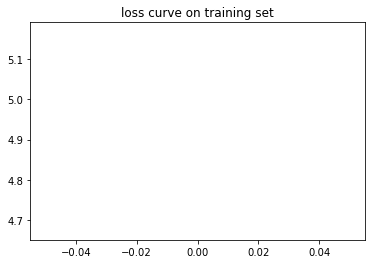

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (0, 0)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 128
    architecture: (None, 1)
    n_conv_layers: 3
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7f55b003d320>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 64
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7f55912134d0>
    weight_decay: 0.1
    num_epochs: 1
    loss_function: MSELoss()
    optimiser: 

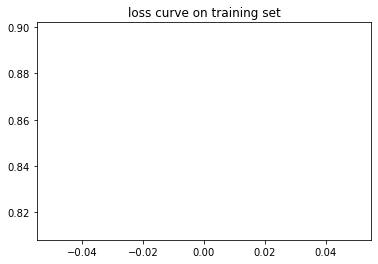

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (0, 1)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 256
    architecture: (None, 1)
    n_conv_layers: 3
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7f55b003d320>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 128
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7f5591213560>
    weight_decay: 0.01
    num_epochs: 1
    loss_function: MSELoss()
    optimiser

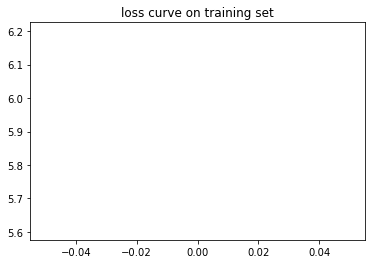

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (1, 0)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 256
    architecture: (None, 1)
    n_conv_layers: 3
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0.25
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7f55b003d320>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 32
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7f5591213560>
    weight_decay: 0.01
    num_epochs: 1
    loss_function: MSELoss()
    optimis

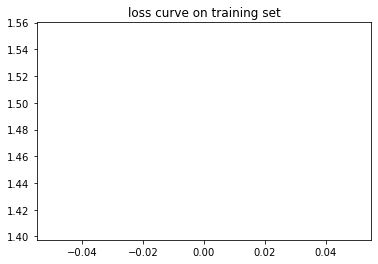

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (1, 1)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 64
    architecture: (None, 1)
    n_conv_layers: 3
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0.25
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7f55b003d320>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 128
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.001
    lr_lambda: <function <lambda> at 0x7f5591213560>
    weight_decay: 0.01
    num_epochs: 1
    loss_function: MSELoss()
    optimi

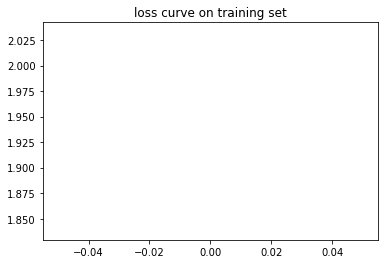

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (2, 0)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 256
    architecture: (None, 1)
    n_conv_layers: 1
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0.25
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7f55b003d320>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 64
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7f55912134d0>
    weight_decay: 0.1
    num_epochs: 1
    loss_function: MSELoss()
    optimise

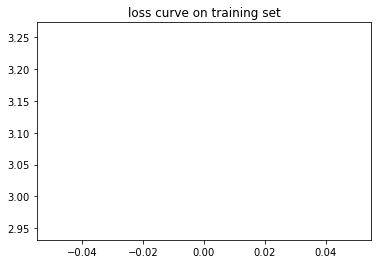

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Subexperiment  (2, 1)  completed. 



In [25]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data (GNN + MLP)
    graph_list_train = [graph_list[k] for k in ind_train_mols]
    graph_list_test = [graph_list[k] for k in ind_test_mols]
    
    # find best hyperparameters via optuna and train associated model on training set (GNN + MLP)
    (trained_best_gnn_model, 
     trained_best_mlp_model, 
     loss_curve_training_set) = train_gnn_mlps_via_optuna(graph_list_train,
                                                          settings_dict["optuna_options"],
                                                          settings_dict["gin_hyperparameter_grid"], 
                                                          settings_dict["mlp_hyperparameter_grid"], 
                                                          settings_dict["train_hyperparameter_grid"])
    # plot learning curves (GNN + MLP)
    plt.plot(loss_curve_training_set)
    plt.title("loss curve on training set")
    plt.show()
    
    # extract learned features from molecular graphs via GNN
    dataloader = GeometricDataLoader(dataset = graph_list, batch_size = len(graph_list), shuffle = False, drop_last = False)
    trained_best_gnn_model.eval()
    for batch in dataloader:
        X_gnn = trained_best_gnn_model(batch.to('cuda' if torch.cuda.is_available() else 'cpu')).cpu().detach().numpy()
           
    # generate training- and test data       
    X_gnn_train = X_gnn[ind_train_mols]
    y_train = y[ind_train_mols]
    
    X_gnn_test = X_gnn[ind_test_mols]
    y_test = y[ind_test_mols]
    
    # instantiate fresh model
    regressor = RandomizedSearchCV(estimator = KNeighborsRegressor(),
                                   param_distributions = settings_dict["hyperparameter_grid"],
                                   n_iter = settings_dict["h_iters"],
                                   cv = settings_dict["j_splits"],
                                   scoring = settings_dict["random_search_scoring"],
                                   verbose = settings_dict["random_search_verbose"],
                                   random_state = settings_dict["random_search_random_state"],
                                   n_jobs = settings_dict["random_search_n_jobs"])

    # fit the model on the training data
    regressor.fit(X_gnn_train, y_train)
    
    # create qsar predictions used to evaluate the model
    y_pred = regressor.predict(X_gnn)
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

In [26]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

Experimental Settings: 
 
target_name = postera_sars_cov_2_mpro
n_molecules = 1924
n_mmps = 10832
method_name = gin_knn
 
k_splits = 2
m_reps = 3
random_state_cv = 42
 
optuna_options = {'h_iters': 1, 'frac_train': 0.8, 'data_splitting_seed': 42, 'performance_metric': <function mean_absolute_error at 0x7f569c3a67a0>, 'direction': 'minimize', 'sampler': <optuna.samplers._tpe.sampler.TPESampler object at 0x7f5591231410>, 'pruner': <optuna.pruners._nop.NopPruner object at 0x7f5591231550>}
 
mlp_hyperparameter_grid = {'architecture': [(None, 1)], 'hidden_activation': [ReLU()], 'output_activation': [Identity()], 'use_bias': [True], 'hidden_dropout_rate': [0], 'hidden_batchnorm': [True]}
 
gin_hyperparameter_grid = {'n_conv_layers': [1, 2, 3], 'input_dim': [79], 'hidden_dim': [64, 128, 256], 'mlp_n_hidden_layers': [2], 'mlp_hidden_activation': [ReLU()], 'mlp_output_activation': [Identity()], 'mlp_use_bias': [True], 'mlp_hidden_dropout_rate': [0, 0.25], 'mlp_hidden_batchnorm': [True], 'eps': 

,MAE,MedAE,RMSE,MaxAE,MSE,Pearson's r,R^2,Test Cases
Avg.,0.5847,0.4957,0.7292,2.8105,0.5328,0.7252,0.5118,962.0
Std.,0.0251,0.0261,0.0306,0.2142,0.0445,0.0255,0.0354,0.0



 

scores_qsar_test 



,MAE,MedAE,RMSE,MaxAE,MSE,Pearson's r,R^2,Test Cases
Avg.,0.6198,0.5169,0.7780,3.1941,0.6067,0.6763,0.4428,962.0
Std.,0.0257,0.0315,0.0308,0.3744,0.0484,0.0289,0.0501,0.0



 

scores_ac_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5473,0.9502,0.4989,0.0023,-0.0020,0.0012,0.9966,0.0556,0.9534,2708.5000,2581.0,127.5000
Std.,0.0705,0.0063,0.0019,0.0023,0.0092,0.0012,0.0033,0.0000,0.0079,173.8333,144.0,29.8333



 

scores_ac_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.8747,0.9550,0.6518,0.4053,0.4074,0.3155,0.988,0.5895,0.9655,5415.0,5149.0,266.0
Std.,0.0235,0.0051,0.0199,0.0498,0.0583,0.0433,0.004,0.0952,0.0020,0.0,0.0,0.0



 

scores_ac_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5315,0.9500,0.4992,0.0037,-0.0039,0.0022,0.9962,0.023,0.9534,2708.5000,2581.0,127.5000
Std.,0.0552,0.0106,0.0013,0.0037,0.0060,0.0022,0.0038,0.000,0.0079,173.8333,144.0,29.8333



 

scores_ac_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6126,0.9365,0.493,0.0,-0.0105,0.0,0.986,0.0,0.9497,184.5000,175.5000,9.0
Std.,0.0433,0.0207,0.007,0.0,0.0105,0.0,0.014,0.0,0.0076,7.8333,8.1667,1.0



 

scores_pd_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6423,0.5973,0.5978,0.5634,0.1936,0.5999,0.5956,0.5319,0.6599,2708.5000,1531.3333,1177.1667
Std.,0.0227,0.0114,0.0115,0.0149,0.0230,0.0199,0.0117,0.0165,0.0239,173.8333,97.3333,113.5000



 

scores_pd_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.7173,0.6535,0.6564,0.6292,0.3100,0.6776,0.6351,0.5873,0.7199,5415.0,3065.3333,2349.6667
Std.,0.0046,0.0049,0.0047,0.0047,0.0093,0.0046,0.0066,0.0054,0.0043,0.0,0.0000,0.0000



 

scores_pd_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6189,0.5806,0.5820,0.5491,0.1624,0.5902,0.5739,0.5145,0.6464,2708.5000,1531.3333,1177.1667
Std.,0.0136,0.0136,0.0147,0.0190,0.0290,0.0230,0.0107,0.0293,0.0263,173.8333,97.3333,113.5000



 

scores_pd_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5471,0.5212,0.5155,0.4787,0.0309,0.4914,0.5397,0.4669,0.5639,184.5000,101.6667,82.8333
Std.,0.0442,0.0453,0.0457,0.0633,0.0909,0.0694,0.0514,0.0576,0.0482,7.8333,9.0000,4.5000



 

scores_pd_ac_pos_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.9469,0.9565,0.9327,0.6296,0.577,0.9444,0.9474,0.9444,0.9474,9.1667,4.1667,5.0
Std.,0.0000,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,8.8333,3.8333,5.0



 

scores_pd_ac_pos_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.9459,0.9163,0.9160,0.9176,0.8322,0.9091,0.923,0.9266,0.9057,145.6667,72.5000,73.1667
Std.,0.0164,0.0295,0.0291,0.0267,0.0591,0.0302,0.028,0.0236,0.0370,31.0000,16.8333,14.1667



 

scores_pd_ac_pos_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.7731,0.6737,0.7596,0.7353,0.3476,0.6905,0.7335,0.8363,0.5128,9.6667,4.5,5.1667
Std.,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,9.6667,4.5,5.1667



 

scores_pd_ac_pos_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6607,0.3667,0.7321,0.375,0.2321,0.75,0.3571,0.375,0.7143,2.6667,1.3333,1.3333
Std.,0.0000,0.0000,0.0000,0.000,0.0000,0.00,0.0000,0.000,0.0000,2.6667,1.3333,1.3333


## GIN + MLP

In [28]:
# set directory for saving of experimental results

settings_dict["method_name"] = "gin_mlp"
filepath = "results/" + settings_dict["target_name"] + "/" + settings_dict["method_name"] + "/"

In [ ]:
# GNN + MLP: hyperparameter- and optuna settings

settings_dict["optuna_options"] = {"h_iters": 20,
                                   "frac_train": 0.8,
                                   "data_splitting_seed": 42,
                                   "performance_metric": mean_absolute_error,
                                   "direction": "minimize",
                                   "sampler": optuna.samplers.TPESampler(), 
                                   "pruner": optuna.pruners.NopPruner()} 

settings_dict["gin_hyperparameter_grid"] = {"n_conv_layers": [1, 2, 3],
                                            "input_dim": [79],
                                            "hidden_dim": [64, 128, 256],
                                            "mlp_n_hidden_layers": [2],
                                            "mlp_hidden_activation": [nn.ReLU()],
                                            "mlp_output_activation": [nn.Identity()],
                                            "mlp_use_bias": [True],
                                            "mlp_hidden_dropout_rate": [0, 0.25],
                                            "mlp_hidden_batchnorm": [True],
                                            "eps": [0],
                                            "train_eps": [False],
                                            "pooling_operation": [global_max_pool]}

settings_dict["mlp_hyperparameter_grid"] = {"architecture": [arch(None, 1, w, d) for (w,d) in all_combs_list([None], [1, 5, 10])],
                                            "hidden_activation": [nn.ReLU()],
                                            "output_activation": [nn.Identity()],
                                            "use_bias": [True],
                                            "hidden_dropout_rate": [0],
                                            "hidden_batchnorm": [True]}

settings_dict["train_hyperparameter_grid"] = {"batch_size": [32, 64, 128], 
                                              "dataloader_shuffle": [True],
                                              "dataloader_drop_last":[True],
                                              "learning_rate": [1e-2, 1e-3],
                                              "lr_lambda": [lambda epoch: max(0.95**epoch, 1e-2), lambda epoch: max(0.99**epoch, 1e-2)],
                                              "weight_decay": [0.1, 0.01],
                                              "num_epochs": [500],
                                              "loss_function": [nn.MSELoss()],
                                              "optimiser": [torch.optim.AdamW],
                                              "performance_metrics": ["regression"],
                                              "print_results_per_epochs": [None]}

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 128
    architecture: (None, None, 1)
    n_conv_layers: 2
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0.25
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7f55b003d320>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 32
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7f55914bd320>
    weight_decay: 0.1
    num_epochs: 1
    loss_function: MSELoss()
    optimiser: <class 'torch.optim.adamw.AdamW'>
    performance_metrics: regression
    print_result

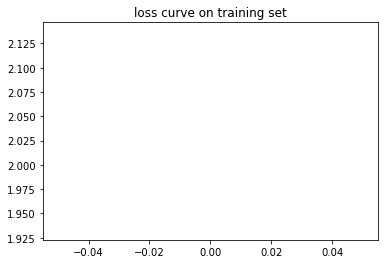

Subexperiment  (0, 0)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 256
    architecture: (None, None, 1)
    n_conv_layers: 1
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7f55b003d320>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 32
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.001
    lr_lambda: <function <lambda> at 0x7f55914bd170>
    weight_decay: 0.1
    num_epochs: 1
    loss_function: MSELoss()
    optimiser: <class 'torch.optim.adamw.AdamW'>
    performance_me

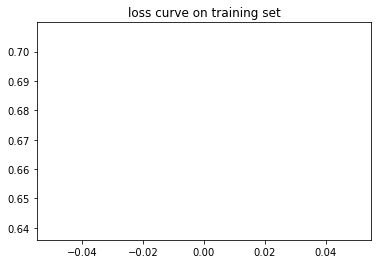

Subexperiment  (0, 1)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 128
    architecture: (None, None, None, None, None, None, None, None, None, None, None, 1)
    n_conv_layers: 1
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0.25
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7f55b003d320>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 32
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7f55914bd320>
    weight_decay: 0.1
    num_epochs: 1
    loss_function: MSELoss()
    optimis

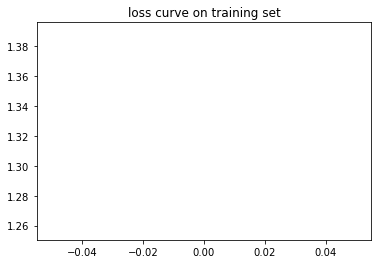

Subexperiment  (1, 0)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 128
    architecture: (None, None, 1)
    n_conv_layers: 1
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0.25
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7f55b003d320>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 64
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7f55914bd170>
    weight_decay: 0.01
    num_epochs: 1
    loss_function: MSELoss()
    optimiser: <class 'torch.optim.adamw.AdamW'>
    performance

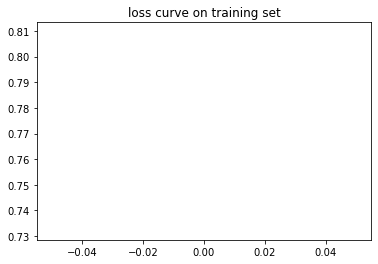

Subexperiment  (1, 1)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 256
    architecture: (None, None, None, None, None, None, None, None, None, None, None, 1)
    n_conv_layers: 1
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0.25
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7f55b003d320>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 128
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7f55914bd170>
    weight_decay: 0.01
    num_epochs: 1
    loss_function: MSELoss()
    optim

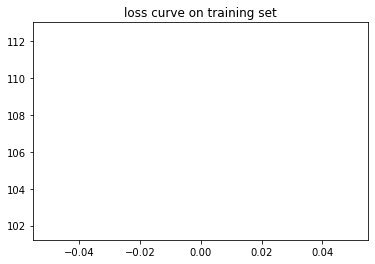

Subexperiment  (2, 0)  completed. 

Trial completed. 


Study statistics: 
  Number of trials:  1
  Number of pruned trials:  0
  Number of completed trials:  1

Hyperarameters of best trial: 
    hidden_dim: 128
    architecture: (None, None, None, None, None, None, None, None, None, None, None, 1)
    n_conv_layers: 1
    input_dim: 79
    mlp_n_hidden_layers: 2
    mlp_hidden_activation: ReLU()
    mlp_output_activation: Identity()
    mlp_use_bias: True
    mlp_hidden_dropout_rate: 0
    mlp_hidden_batchnorm: True
    eps: 0
    train_eps: False
    pooling_operation: <function global_max_pool at 0x7f55b003d320>
    hidden_activation: ReLU()
    output_activation: Identity()
    use_bias: True
    hidden_dropout_rate: 0
    hidden_batchnorm: True
    batch_size: 32
    dataloader_shuffle: True
    dataloader_drop_last: True
    learning_rate: 0.01
    lr_lambda: <function <lambda> at 0x7f55914bd170>
    weight_decay: 0.01
    num_epochs: 1
    loss_function: MSELoss()
    optimiser

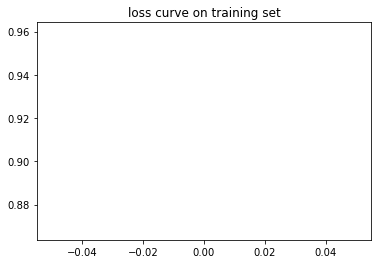

Subexperiment  (2, 1)  completed. 



In [30]:
# model evaluation via m-times repeated k-fold cross validation
start_time = time.time()

# preallocate dictionary with cubic arrays used to save prediction values and performance scores over all m*k experiments
scores_dict = create_scores_dict(k_splits = settings_dict["k_splits"], 
                                 m_reps = settings_dict["m_reps"], 
                                 len_y = settings_dict["n_molecules"])

# train and evaluate models
for (m, k) in data_split_dictionary.keys():
    
    # extract indices for D_train and D_test for this data split
    (ind_train_mols, ind_test_mols) = data_split_dictionary[(m,k)][0:2]
    
    # generate training- and test data
    graph_list_train = [graph_list[k] for k in ind_train_mols]
    y_train = y[ind_train_mols]
    
    graph_list_test = [graph_list[k] for k in ind_test_mols]
    y_test = y[ind_test_mols]
    
    # find best hyperparameters via optuna and train associated model on training set
    (trained_best_gnn_model, 
     trained_best_mlp_model, 
     loss_curve_training_set) = train_gnn_mlps_via_optuna(graph_list_train,
                                                          settings_dict["optuna_options"],
                                                          settings_dict["gin_hyperparameter_grid"], 
                                                          settings_dict["mlp_hyperparameter_grid"], 
                                                          settings_dict["train_hyperparameter_grid"])
    # plot learning curves
    plt.plot(loss_curve_training_set)
    plt.title("loss curve on training set")
    plt.show()
    
    # create qsar predictions used to evaluate the model
    dataloader = GeometricDataLoader(dataset = graph_list, batch_size = len(graph_list), shuffle = False, drop_last = False)
    trained_best_gnn_model.eval()
    trained_best_mlp_model.eval()
    for batch in dataloader:
        y_pred = trained_best_mlp_model(trained_best_gnn_model(batch.to('cuda' if torch.cuda.is_available() else 'cpu'))).cpu().detach().numpy()[:,0]
    
    create_and_store_qsar_ac_pd_results(scores_dict, x_smiles, X_smiles_mmps,
                                        y, y_mmps, y_mmps_pd, y_pred,
                                        data_split_dictionary, m, k)
    
    # give feedback on completion of this subexperiment
    print("Subexperiment ", (m,k), " completed. \n")

# save experimental results
save_qsar_ac_pd_results(filepath, scores_dict)

# save experimental settings
settings_dict["runtime"] = str(time.strftime("%H:%M:%S", time.gmtime(time.time() - start_time)))
save_experimental_settings(filepath, settings_dict)

In [31]:
# display experimental results and settings
display_experimental_results(filepath, decimals = 4)

Experimental Settings: 
 
target_name = postera_sars_cov_2_mpro
n_molecules = 1924
n_mmps = 10832
method_name = gin_mlp
 
k_splits = 2
m_reps = 3
random_state_cv = 42
 
optuna_options = {'h_iters': 1, 'frac_train': 0.8, 'data_splitting_seed': 42, 'performance_metric': <function mean_absolute_error at 0x7f569c3a67a0>, 'direction': 'minimize', 'sampler': <optuna.samplers._tpe.sampler.TPESampler object at 0x7f575cca2f50>, 'pruner': <optuna.pruners._nop.NopPruner object at 0x7f575ccb10d0>}
 
mlp_hyperparameter_grid = {'architecture': [(None, None, 1), (None, None, None, None, None, None, 1), (None, None, None, None, None, None, None, None, None, None, None, 1)], 'hidden_activation': [ReLU()], 'output_activation': [Identity()], 'use_bias': [True], 'hidden_dropout_rate': [0], 'hidden_batchnorm': [True]}
 
gin_hyperparameter_grid = {'n_conv_layers': [1, 2, 3], 'input_dim': [79], 'hidden_dim': [64, 128, 256], 'mlp_n_hidden_layers': [2], 'mlp_hidden_activation': [ReLU()], 'mlp_output_activation

,MAE,MedAE,RMSE,MaxAE,MSE,Pearson's r,R^2,Test Cases
Avg.,2.1143,1.9808,2.5966,8.0158,18.8009,0.2775,-16.0890,962.0
Std.,1.3829,1.3215,1.7118,4.1858,18.0149,0.3451,16.3597,0.0



 

scores_qsar_test 



,MAE,MedAE,RMSE,MaxAE,MSE,Pearson's r,R^2,Test Cases
Avg.,2.132,2.1208,2.6079,7.2766,19.0293,0.2827,-16.6029,962.0
Std.,1.399,1.4538,1.7215,3.8895,18.2426,0.3447,16.8894,0.0



 

scores_ac_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.4490,0.8373,0.4920,0.0190,-0.0110,0.1131,0.8709,0.0157,0.9532,2708.5000,2581.0,127.5000
Std.,0.0729,0.0803,0.0119,0.0161,0.0147,0.1070,0.0840,0.0129,0.0066,173.8333,144.0,29.8333



 

scores_ac_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.633,0.7501,0.5588,0.1677,0.1032,0.3464,0.7712,0.1366,0.9555,5415.0,5149.0,266.0
Std.,0.129,0.1560,0.0910,0.1065,0.1387,0.1549,0.1629,0.1008,0.0108,0.0,0.0,0.0



 

scores_ac_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.4378,0.8540,0.4924,0.0191,-0.0056,0.0926,0.8922,0.0871,0.9522,2708.5000,2581.0,127.5000
Std.,0.0228,0.0857,0.0039,0.0103,0.0043,0.0839,0.0894,0.0023,0.0072,173.8333,144.0,29.8333



 

scores_ac_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.4720,0.8894,0.5115,0.0457,0.0340,0.0924,0.9306,0.2652,0.9516,184.5000,175.5000,9.0
Std.,0.0706,0.0632,0.0141,0.0457,0.0435,0.0924,0.0643,0.0152,0.0089,7.8333,8.1667,1.0



 

scores_pd_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5596,0.5338,0.5343,0.4997,0.0680,0.5377,0.5309,0.4675,0.5999,2708.5000,1531.3333,1177.1667
Std.,0.0251,0.0144,0.0143,0.0260,0.0287,0.0173,0.0146,0.0349,0.0136,173.8333,97.3333,113.5000



 

scores_pd_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6236,0.5706,0.5721,0.5411,0.1429,0.5836,0.5606,0.5045,0.6372,5415.0,3065.3333,2349.6667
Std.,0.0366,0.0299,0.0308,0.0333,0.0610,0.0375,0.0242,0.0298,0.0307,0.0,0.0000,0.0000



 

scores_pd_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5349,0.5236,0.5244,0.4880,0.0480,0.5253,0.5235,0.4568,0.5905,2708.5000,1531.3333,1177.1667
Std.,0.0487,0.0315,0.0321,0.0371,0.0639,0.0386,0.0260,0.0356,0.0439,173.8333,97.3333,113.5000



 

scores_pd_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5167,0.5157,0.5123,0.4738,0.0248,0.4877,0.5370,0.4620,0.5628,184.5000,101.6667,82.8333
Std.,0.0239,0.0278,0.0302,0.0494,0.0603,0.0423,0.0255,0.0562,0.0225,7.8333,9.0000,4.5000



 

scores_pd_ac_pos_train 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.6314,0.6582,0.7237,0.5628,0.3710,0.8232,0.6241,0.4708,0.8434,354.6667,203.0,151.6667
Std.,0.0736,0.0791,0.0796,0.0986,0.1591,0.0882,0.0710,0.1073,0.0517,236.6667,149.0,87.6667



 

scores_pd_ac_pos_inter 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.8173,0.7857,0.7870,0.7753,0.5727,0.7982,0.7757,0.7557,0.8157,1263.8333,685.8333,578.0000
Std.,0.1256,0.1277,0.1263,0.1369,0.2542,0.1143,0.1384,0.1563,0.0994,827.5000,466.1667,361.3333



 

scores_pd_ac_pos_test 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5650,0.5959,0.5965,0.6199,0.1952,0.6564,0.5365,0.5941,0.6036,291.0000,149.6667,141.3333
Std.,0.0995,0.0992,0.1001,0.1066,0.1994,0.0971,0.1032,0.1170,0.0816,241.3333,127.3333,114.0000



 

scores_pd_ac_pos_cores 



,AUROC,Accuracy,Balanced Accuracy,F1-Score,MCC,Sensitivity,Specificity,Precision,Negative Predictive Value,Test Cases,Negative Test Cases,Positive Test Cases
Avg.,0.5776,0.5813,0.7038,0.3371,0.2035,0.5833,0.6622,0.4244,0.7788,14.5,6.6667,7.8333
Std.,0.0776,0.0020,0.0462,0.0038,0.0465,0.0833,0.0878,0.0756,0.0288,13.5,6.3333,7.1667


# Visual Data Analysis

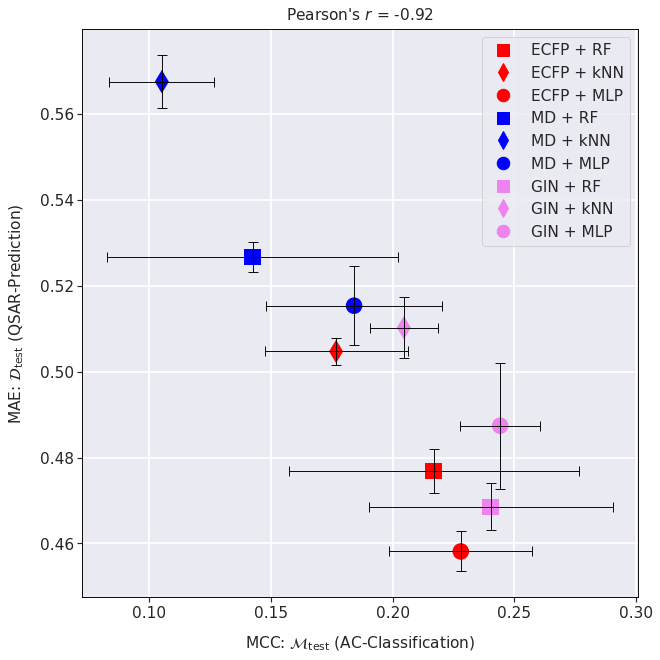

In [26]:
# plot results

# targets: chembl_dopamine_d2, chembl_factor_xa, postera_sars_cov_2_mpro
# tasks: "qsar_train", "qsar_test", "ac_train", "ac_inter", "ac_test", "ac_cores", "pd_train", "pd_inter", "pd_test", "pd_cores", "pd_ac_pos_train", "pd_ac_pos_inter", "pd_ac_pos_test", "pd_ac_pos_cores"
# regression metrics: "MAE", "MedAE", "RMSE", "MaxAE", "MSE", "Pearson's r", "R^2", "Test Cases"
# classification metrics: "AUROC", "Accuracy", "Balanced Accuracy", "F1-Score", "MCC", "Sensitivity", "Specificity", "Precision", "Negative Predictive Value", "Test Cases", "Negative Test Cases", "Positive Test Cases" 

visualise_results(target = "chembl_dopamine_d2",
                  task_x = "ac_test",
                  metric_x = "MCC",
                  task_y = "qsar_test",
                  metric_y = "MAE",
                  plot_legend = True,
                  legend_loc = "upper right",
                  plot_title = True,
                  plot_x_label = True,
                  plot_y_label = True,
                  plot_error_bars = True,
                  size = 14, 
                  filepath_to_save = "figures/scatter.svg")